In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, entropy
from sklearn.tree import export_graphviz
from IPython.display import Image

from UtilFunctions import format_season

In [4]:
df = pd.read_csv(f"DataCollection/Player_Stats/player_stats_2019-20.csv")

shooting_data = pd.read_csv(f"DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_2019-20.csv")
df = pd.merge(df, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])
df.drop(columns=['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', '2PAr', 'FT', 'FG', 'FG%', 'BLK', 'STL', 'Dunks', 
                                  'Heaves', 'HeavesAttempted', 'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP'], inplace=True)
len(df.columns)

KeyError: "['index', '2PAr', 'Dunks', 'Heaves', 'HeavesAttempted'] not found in axis"

In [2]:
def pre_process(seasons, training_seasons):
    df = None
    for season in seasons:
        per_min_cols = ['FGA', '3PA', '2PA', 'PF', 'PTS', 'OWS', 'DWS', 'OBPM', 'DBPM', 'BPM']
        cols_to_drop = None
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        if seasons[0] > 1997 and (len(seasons) > 1 or seasons[0] > 1997+training_seasons):
            cols_to_drop = ['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', '2PAr', 'FT', 'FG', 'FG%', 'BLK', 'STL', 'Dunks', 
                                  'Heaves', 'HeavesAttempted', 'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP']
            shooting_data = pd.read_csv(f"DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_{first_year}-{second_year}.csv")
            player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])

        else:
            cols_to_drop = ['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', 'FT', 'FG', 'FG%', 'BLK', 'STL',
                                'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP']
            
        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data.sort_values(by=['G'], ascending=False)
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
        player_data.reset_index(inplace=True)
        player_data.drop(columns=cols_to_drop, inplace=True)
        
        for col in per_min_cols:
            player_data[col] = player_data[col] / player_data['MP'] * 36
        
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
    df.reset_index(inplace=True)
    df.drop(['index', 'Player', 'Tm'], axis=1, inplace=True)
    return df

In [3]:
#teste de normalizar features
def random_forest_classify(X_train, y_train):
    rf = RandomForestClassifier()
    rand_search = RandomizedSearchCV(rf, param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1, 20)},
                                 n_iter = 5, cv = 5, random_state=42)
    rand_search.fit(X_train, y_train)
    return rand_search.best_estimator_

In [4]:
def plot_feature_importances(importances, estimators, features):
    fi = pd.Series(importances, index=features).sort_values(ascending=False)
    #std = np.std([tree.feature_importances_ for tree in estimators], axis=0)
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.bar(fi.index, fi)
    ax.tick_params('x', labelrotation=90)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")

In [5]:
def train_test_split(seasons, training_seasons):
    train_df = pre_process(seasons[:-1], training_seasons)
    test_df = pre_process(seasons[-1:], training_seasons)
    return train_df.loc[:, ~train_df.columns.isin(['Pos'])], test_df.loc[:, ~test_df.columns.isin(['Pos'])], train_df['Pos'], test_df['Pos']

In [6]:
def calculate_probability_matrix(cm):
    prob_matrix = []
    for i in range(len(cm)):
        prob_matrix.append([])
        players_in_position = sum(cm[i,:])
        for j in range(len(cm)):
            prob_matrix[i].append(round(cm[i,j]/players_in_position, 2))
    
    return prob_matrix

In [7]:
def entropy_by_position(positions, p_matrix):
    entropies = {}
    i = 0
    for position in positions:
        entropies[position] = entropy(p_matrix[i])
        i += 1
    return entropies

In [8]:
def classify_year_by_year(seasons, training_seasons=4):
    entropies_df = pd.DataFrame()
    f1_scores = pd.DataFrame()
    feature_importances = pd.DataFrame()
    for season in seasons:
        X_train, X_test, y_train, y_test = train_test_split(range(season,season+training_seasons+1), training_seasons)
        rf = random_forest_classify(X_train, y_train)
        y_pred = rf.predict(X_test)
        labels = ["PG", "SG", "SF", "PF", "C"]
        cm = confusion_matrix(y_test, y_pred, labels=labels)
        ConfusionMatrixDisplay(cm, display_labels=labels).plot()
        prob_matrix = calculate_probability_matrix(cm)
        entropies_df[season+training_seasons] = entropy_by_position(labels, prob_matrix)
        f1_scores[season+training_seasons] = f1_score(y_test, y_pred, average='micro')
        fi = {k:v for k,v in zip(X_train.columns,rf.feature_importances_)}
        feature_importances[season] = fi
    
    return entropies_df, f1_scores, feature_importances

In [9]:
stats_mapper = {
    'MP' : "Usage", 
    'FGA' : "Usage", 
    '3PA' : "Usage", 
    '3P%' : "Shooting", 
    '2PA' : "Usage", 
    '2P%' : "Shooting", 
    'eFG%' : "Shooting", 
    'FT%' : "Shooting", 
    'PF' : "Defensive", 
    'PTS' : "Shooting",
    'PER' : "General", 
    'TS%' : "Shooting", 
    '3PAr' : "Usage", 
    'FTr' : "Usage", 
    'ORB%' : "Rebounding", 
    'DRB%' : "Rebounding", 
    'TRB%' : "Rebounding", 
    'AST%' : "Playmaking", 
    'STL%' : "Defensive",
    'BLK%' : "Defensive", 
    'TOV%' : "Playmaking", 
    'USG%' : "Usage", 
    'OWS' : "General", 
    'DWS' : "General", 
    'WS/48' : "General", 
    'OBPM' : "General", 
    'DBPM' : "General", 
    'BPM' : "General",
    'Salary' : "Salary"
}

color_mapper = {
    "Usage" : 'red',
    "Defensive": 'blue',
    "Shooting": 'green',
    "General": 'orange',
    "Rebounding" : 'purple',
    "Playmaking": 'darkgoldenrod',
    "Salary": 'slategray'
}

# 2 training seasons

C:\Users\mathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


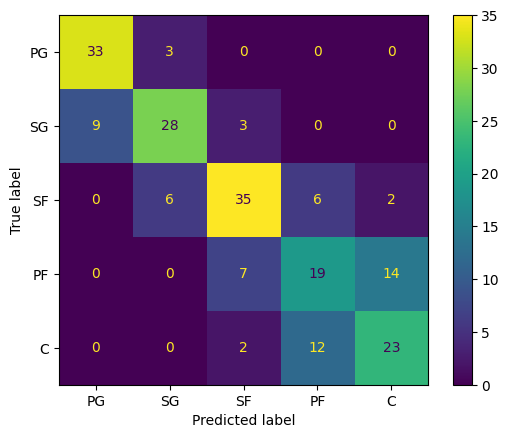

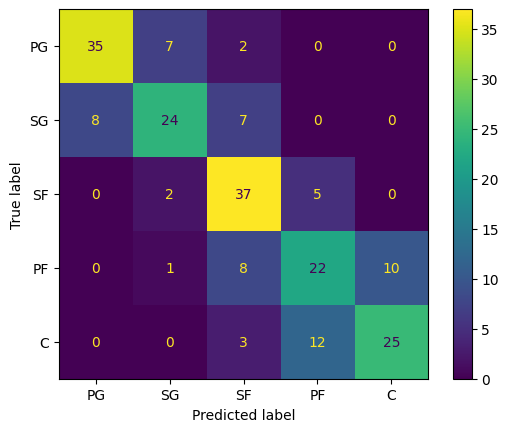

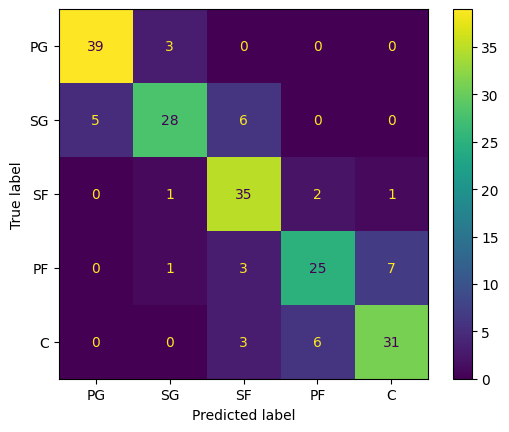

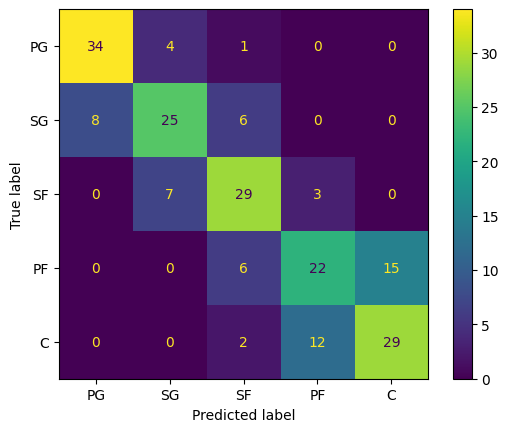

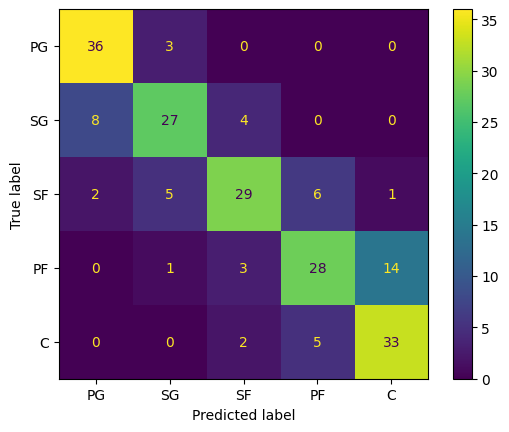

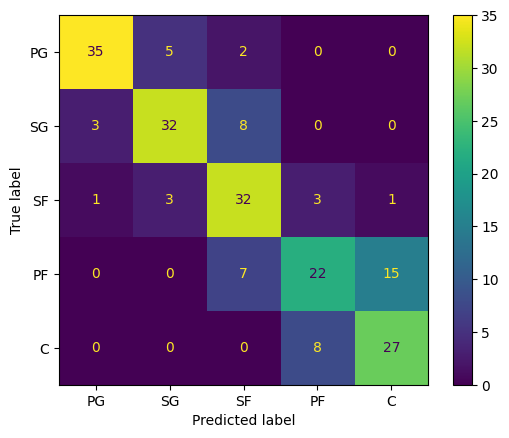

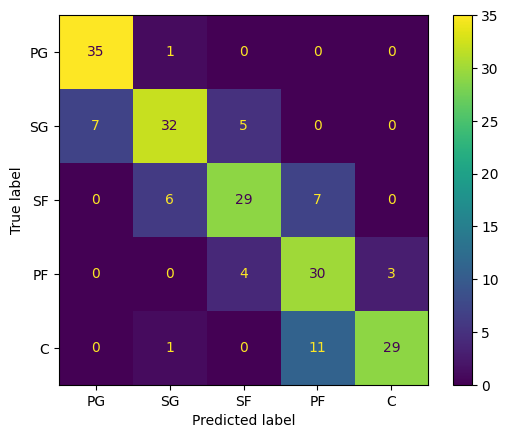

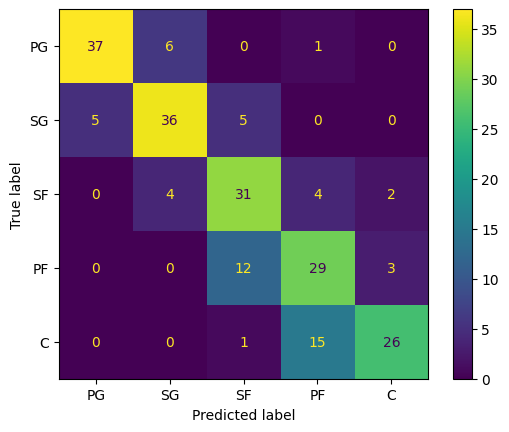

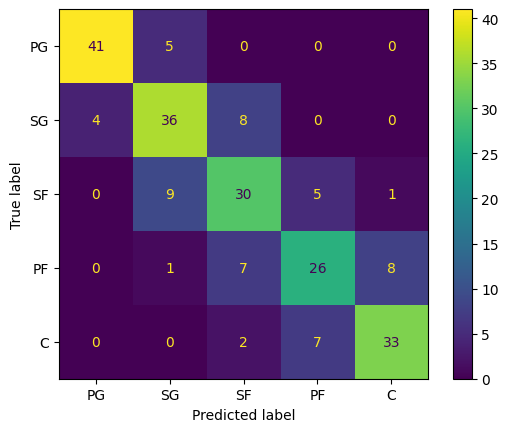

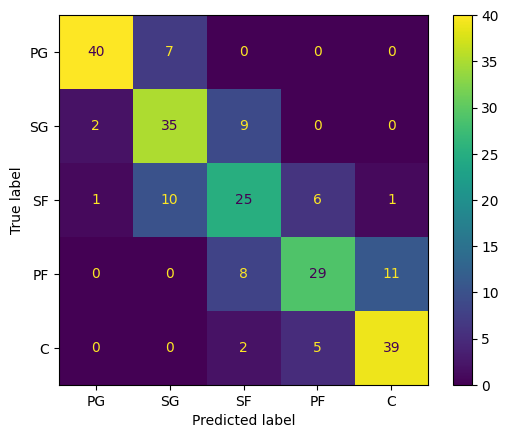

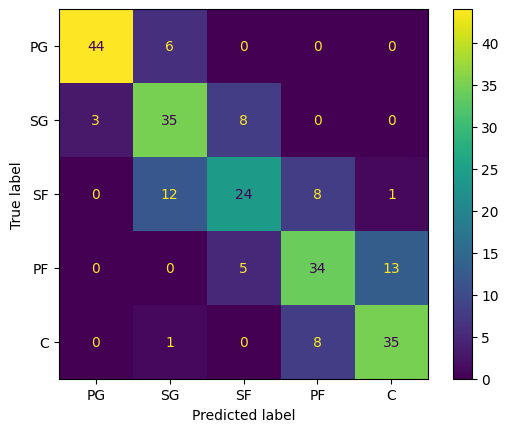

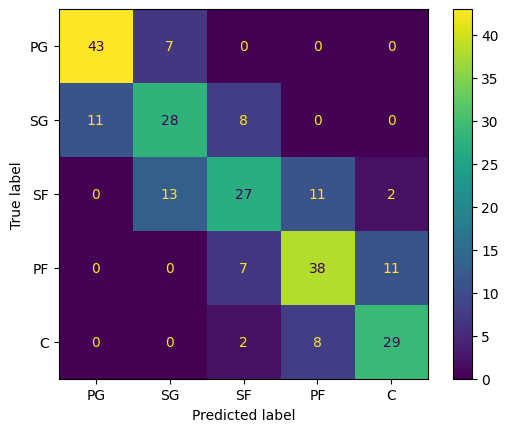

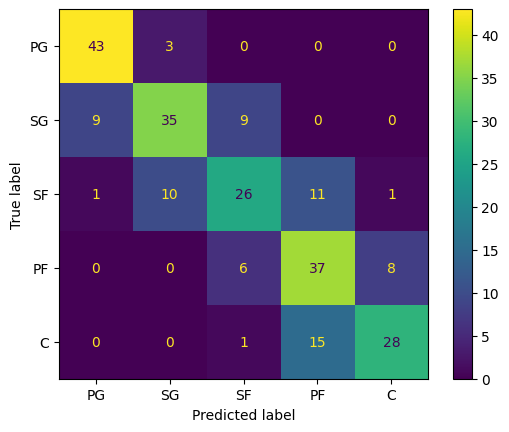

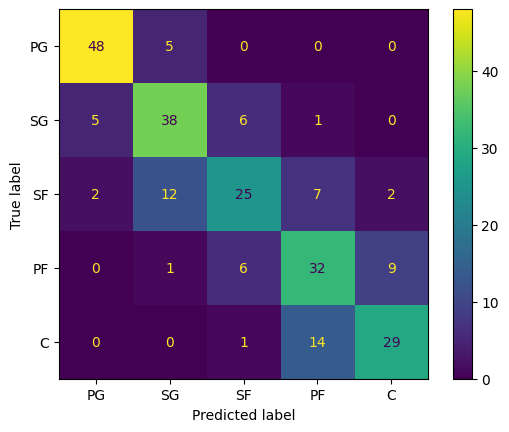

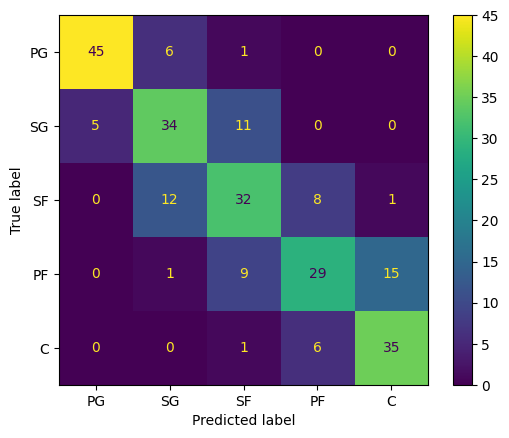

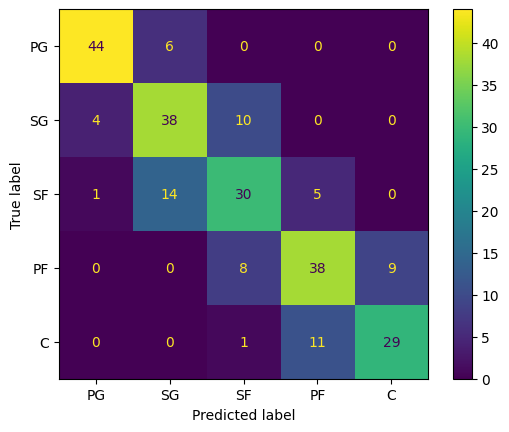

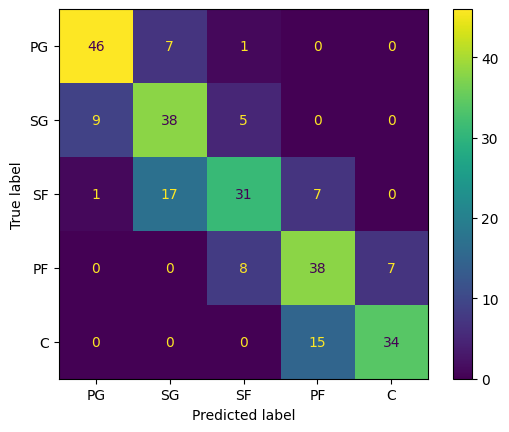

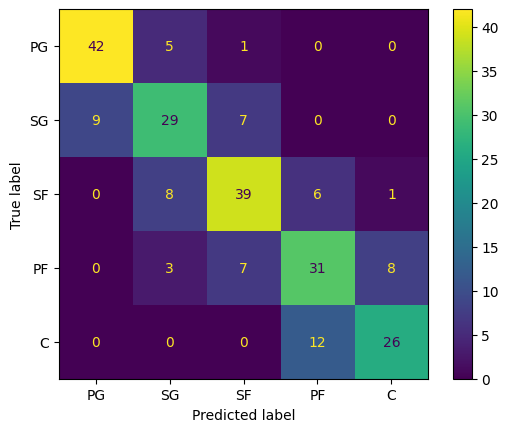

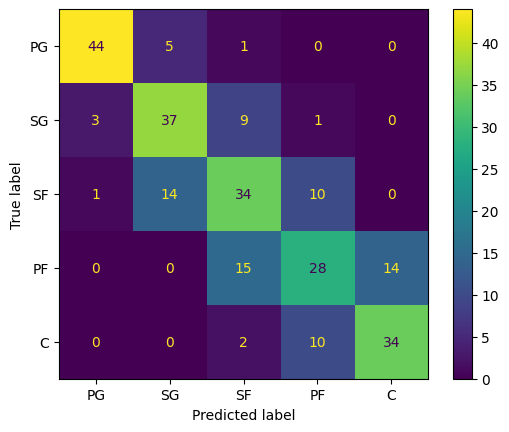

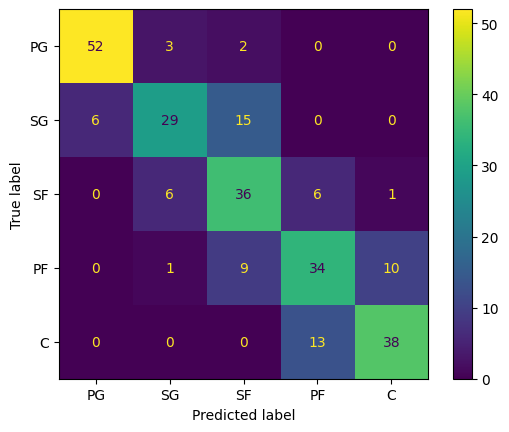

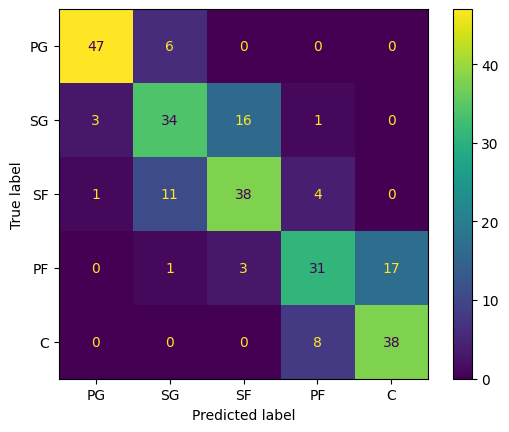

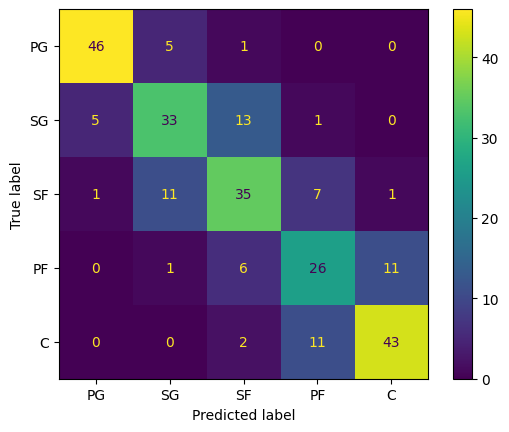

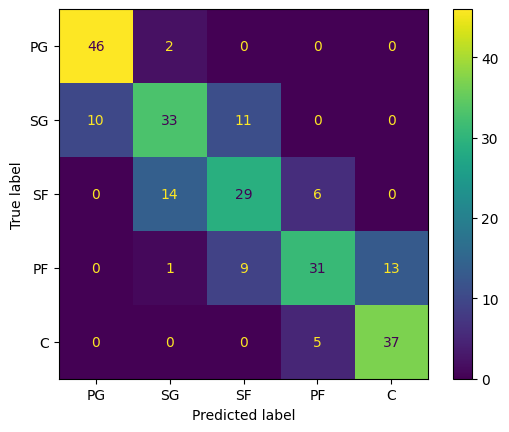

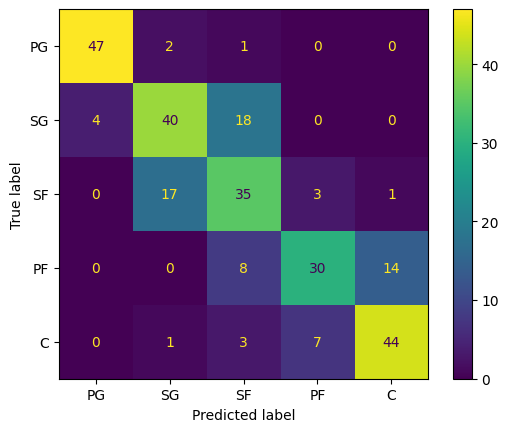

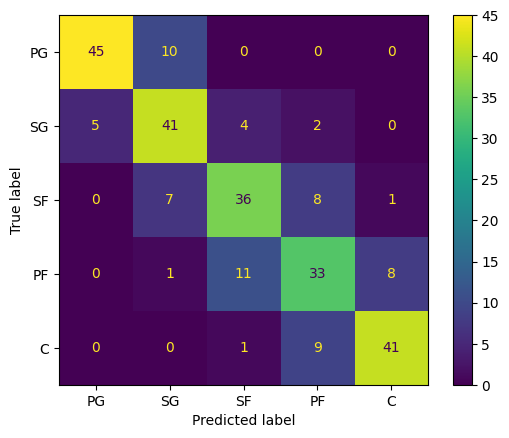

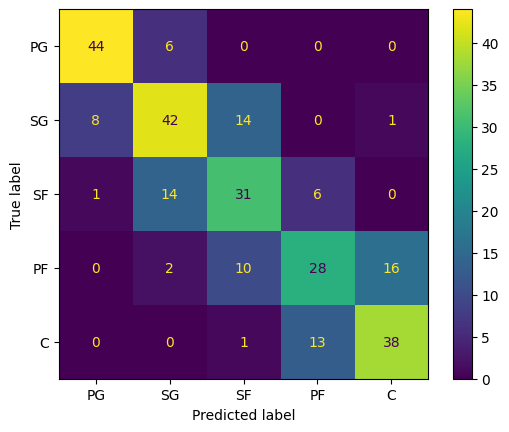

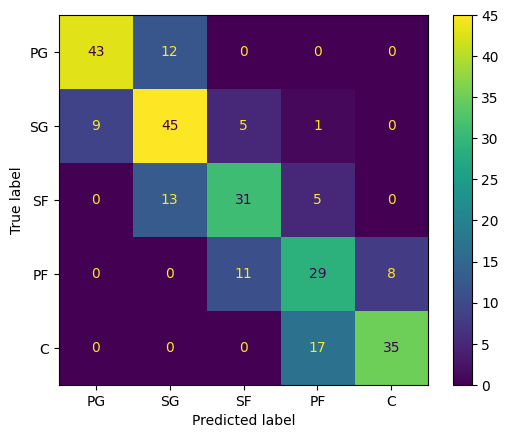

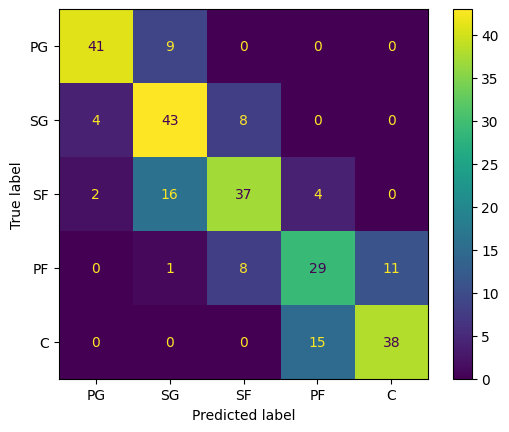

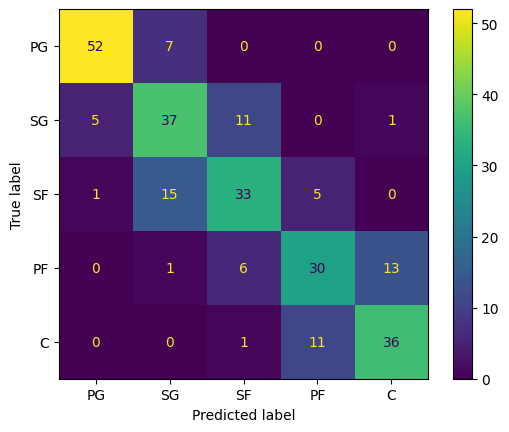

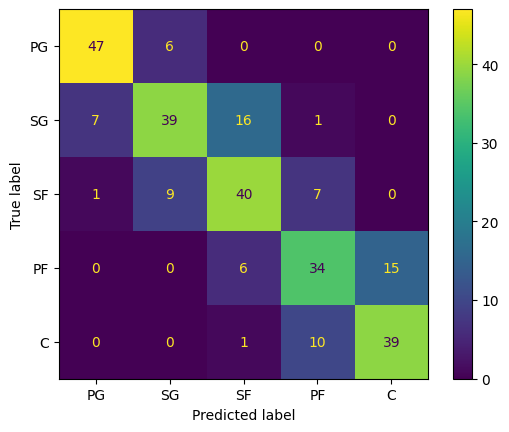

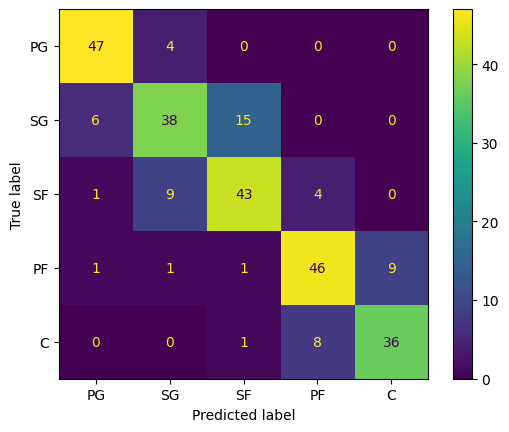

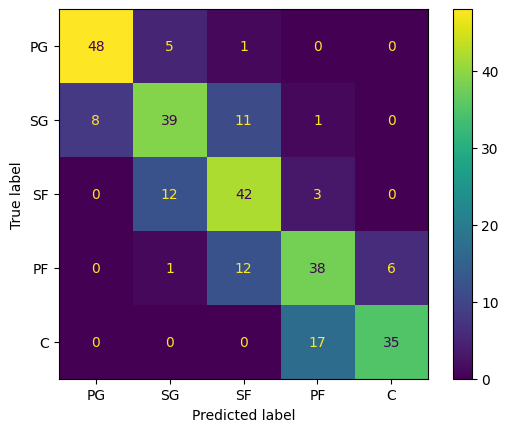

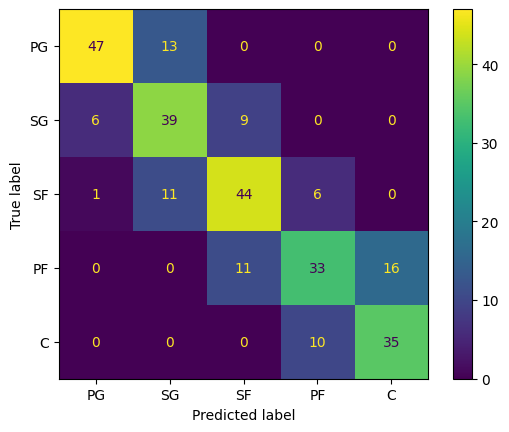

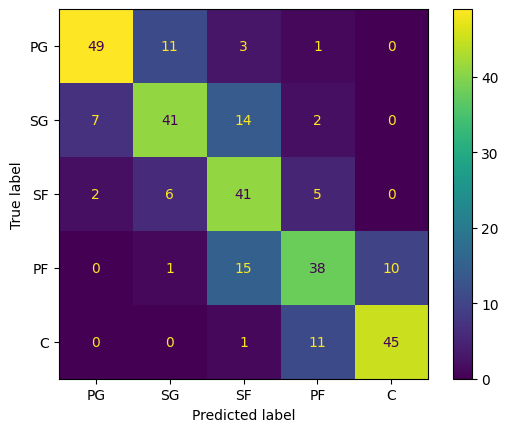

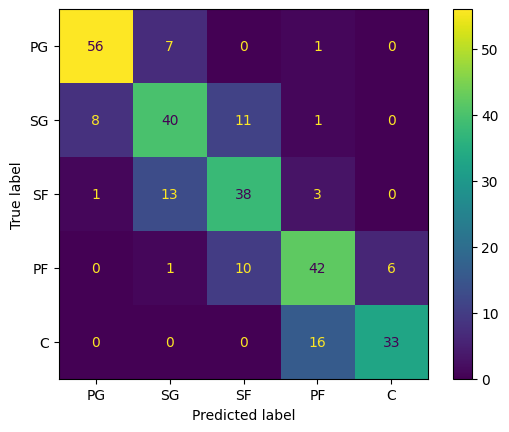

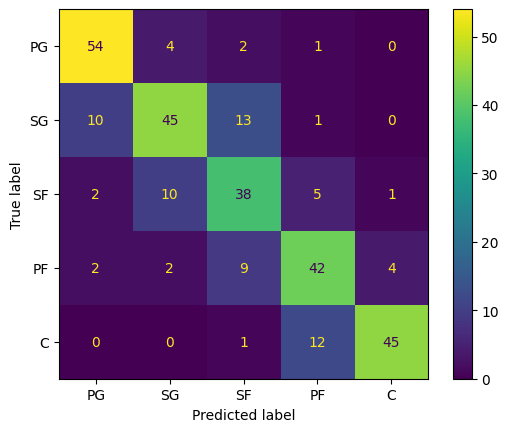

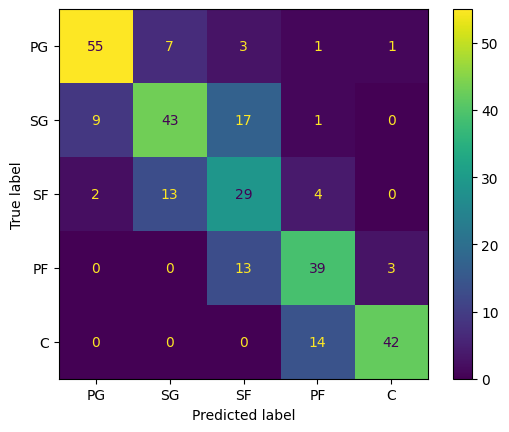

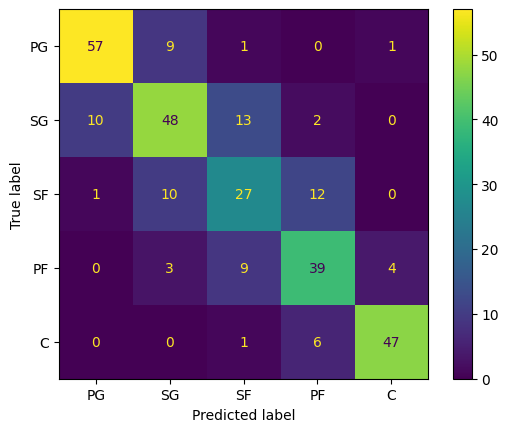

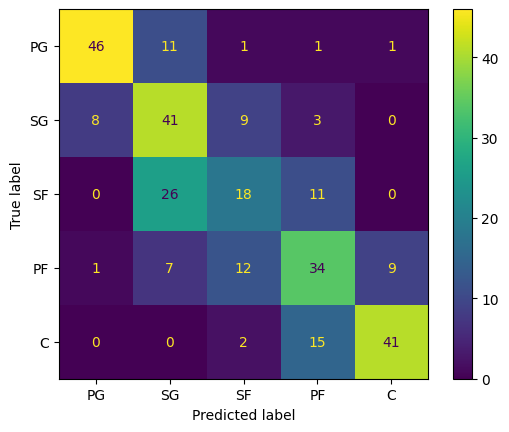

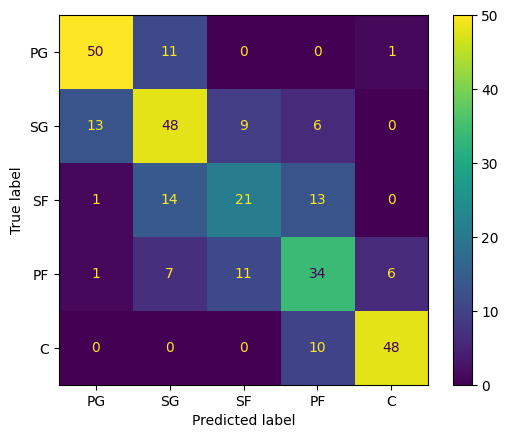

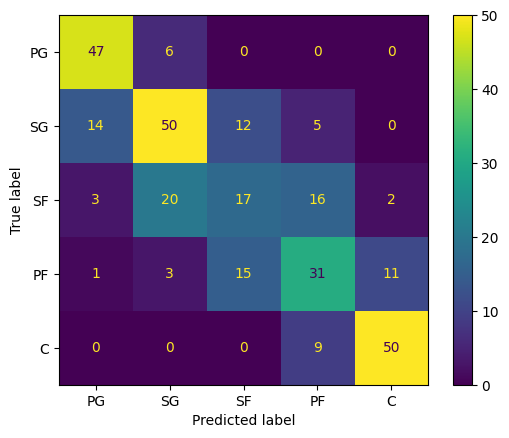

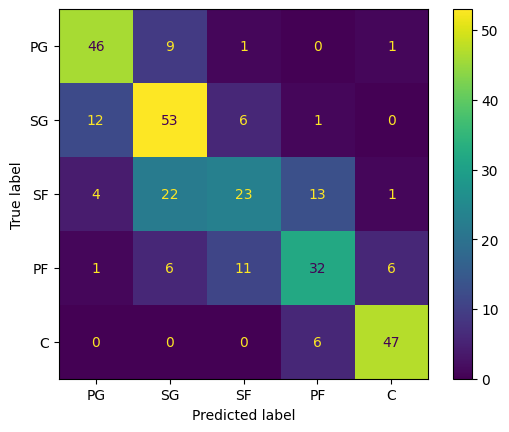

In [10]:
entropies_df, scores, feature_importances = classify_year_by_year(range(1980, 2022), 2)

<Axes: >

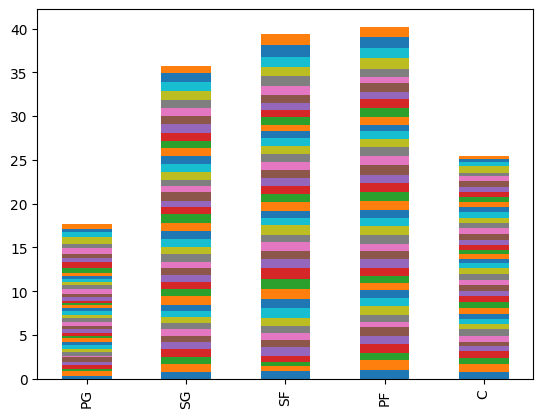

In [11]:
entropies_df.plot(kind='bar', stacked=True, legend=False)

<Axes: >

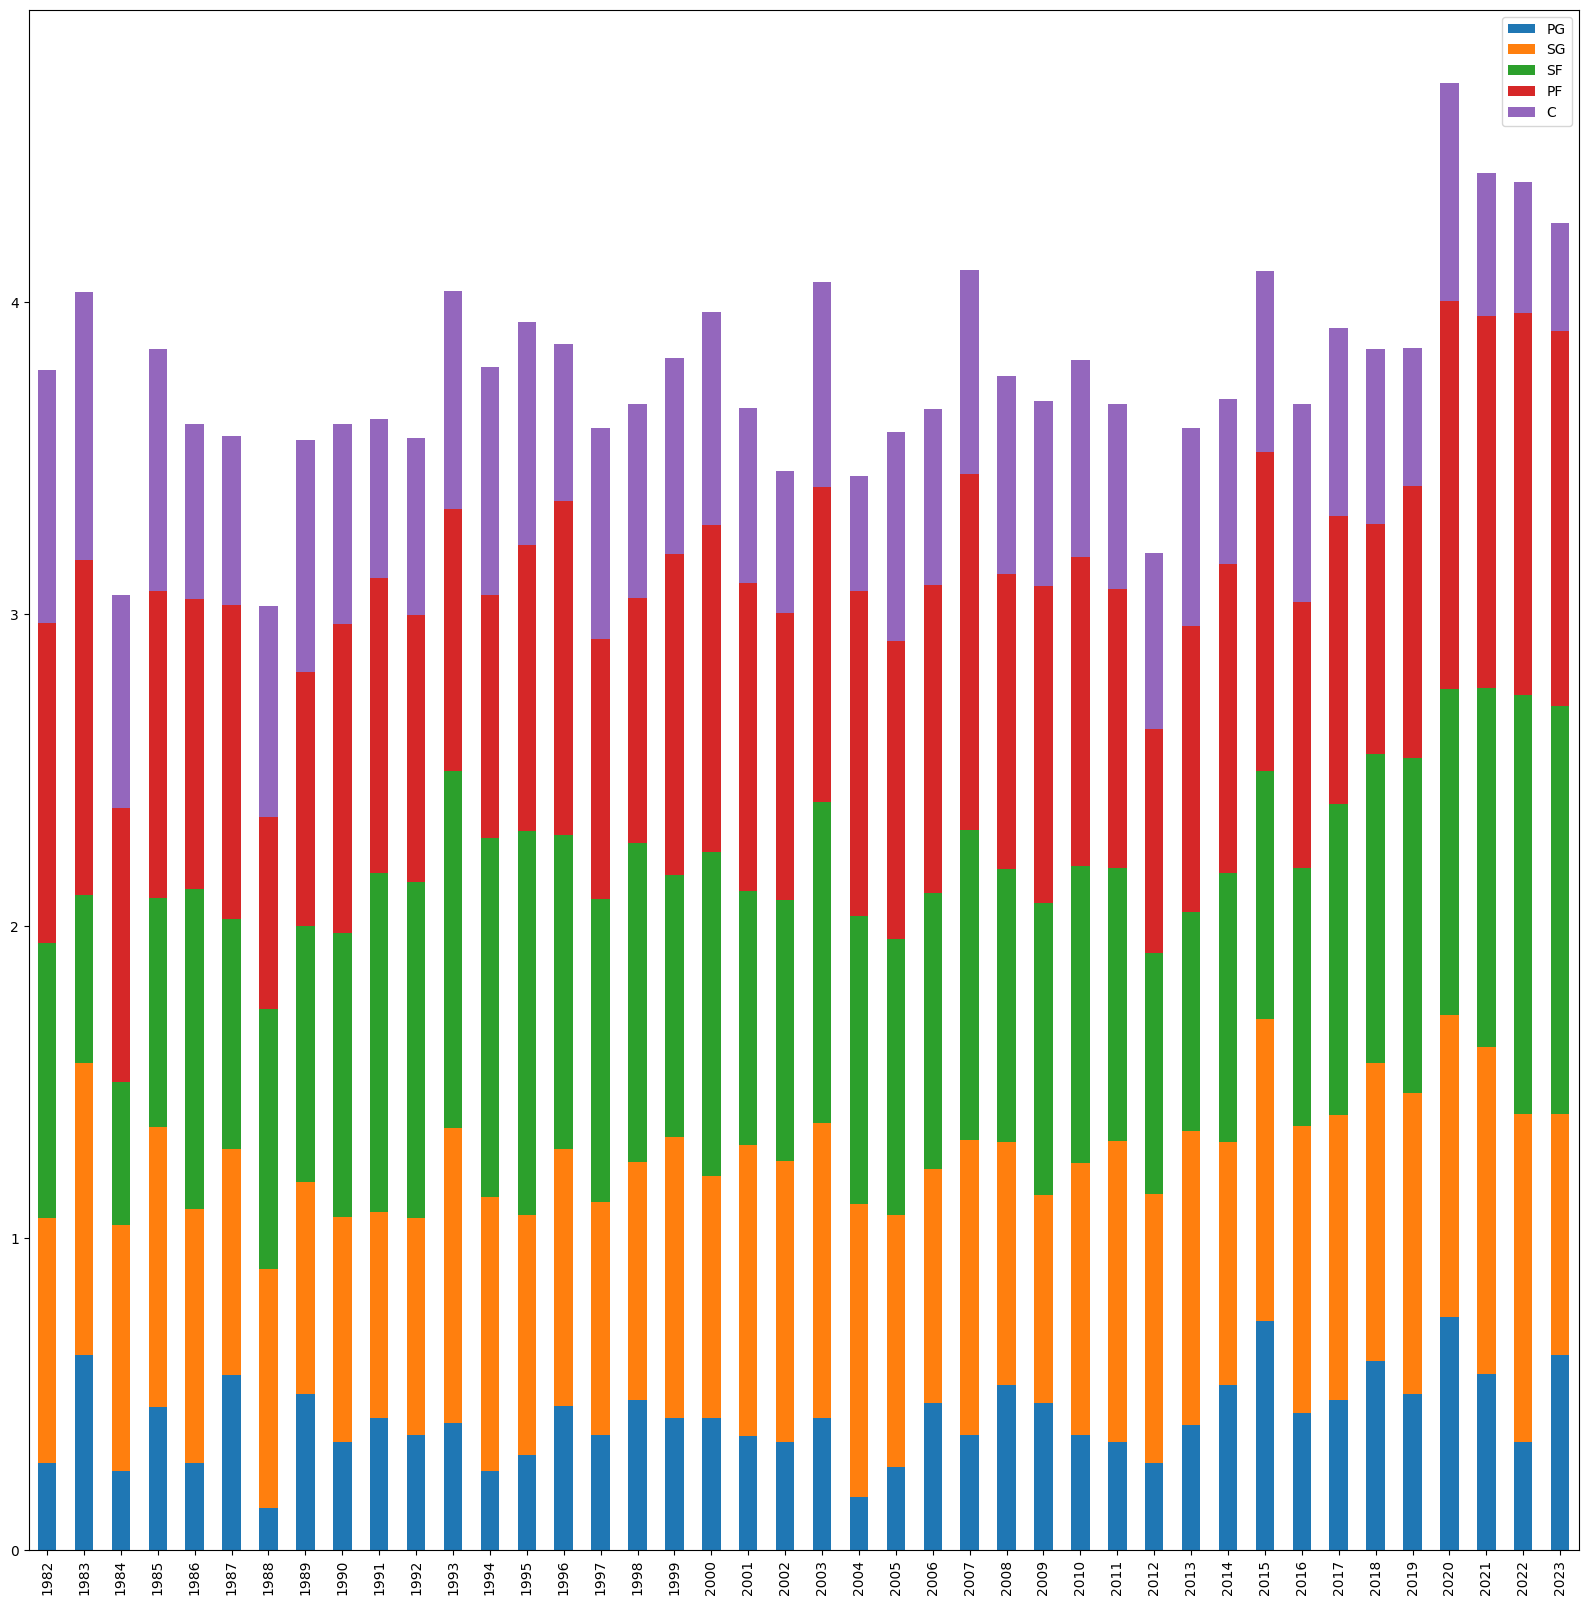

In [12]:
entropies_df.transpose().plot(kind='bar', stacked=True, figsize=(20,20))

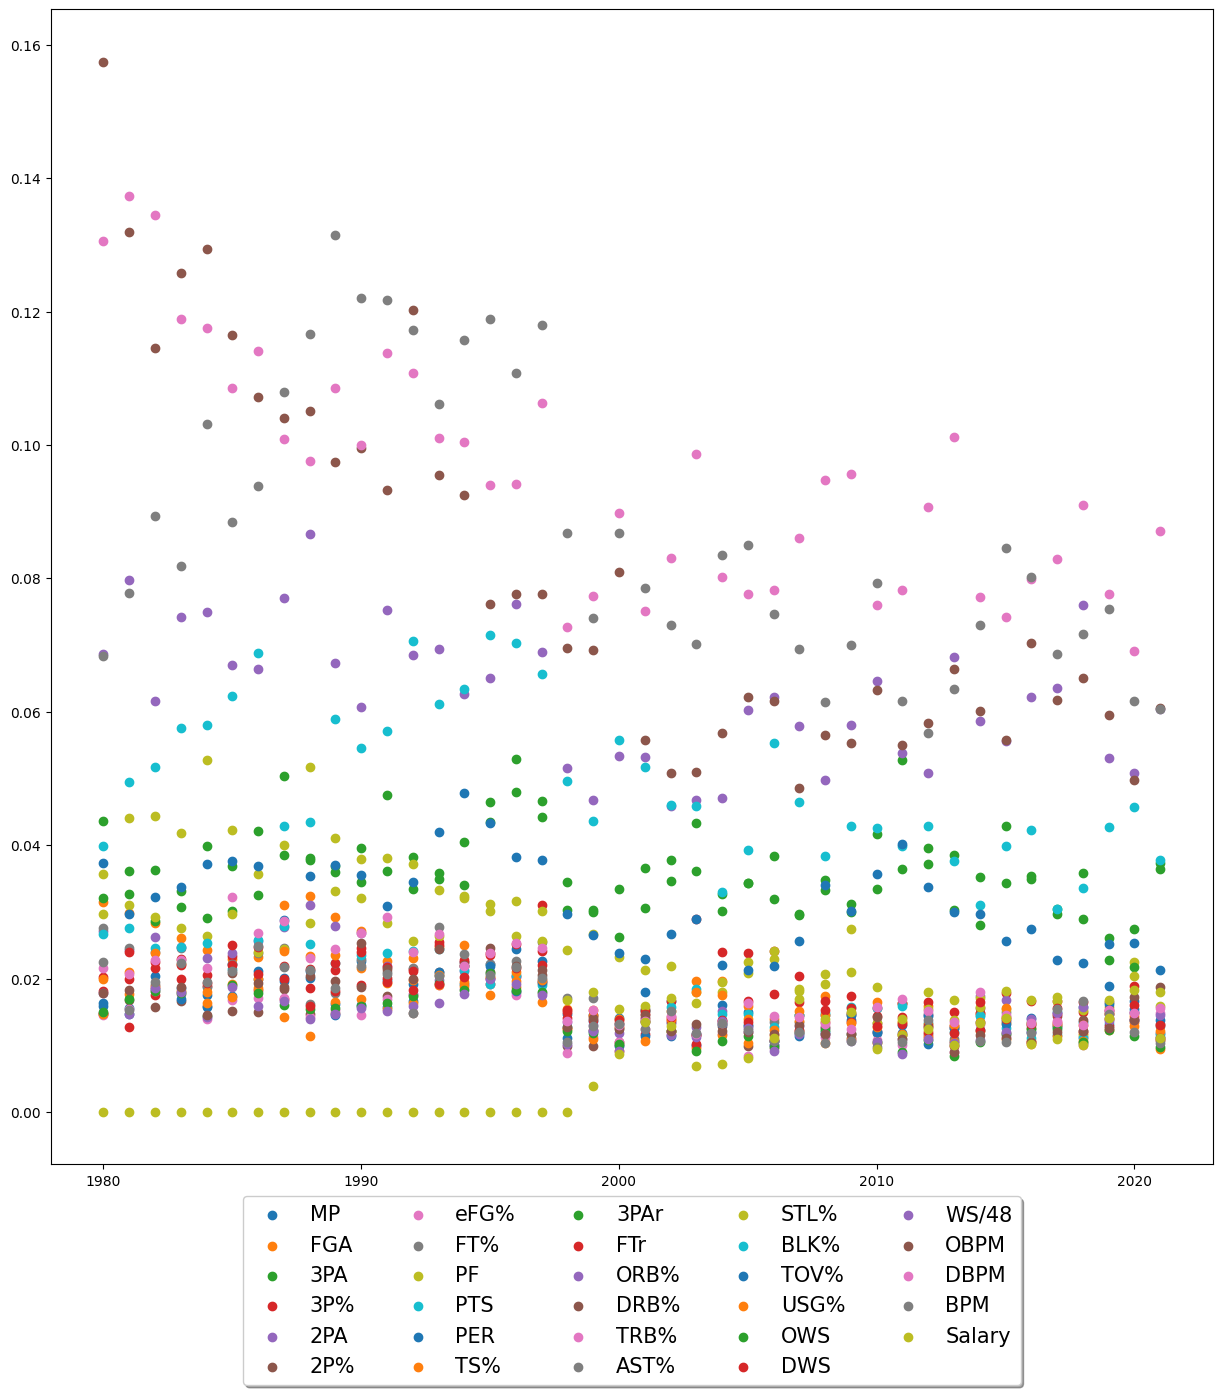

In [13]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=stats_mapper[idx], color=color_mapper[stats_mapper[idx]], alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='lower center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, prop={'size': 15})

plt.show()

# 3 training seasons

C:\Users\mathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


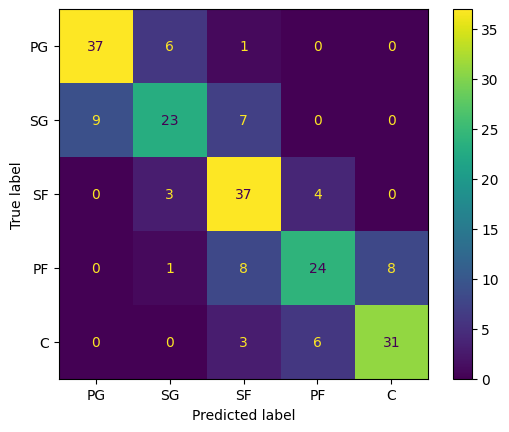

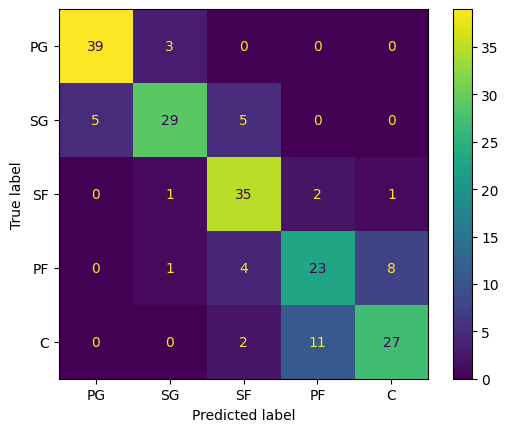

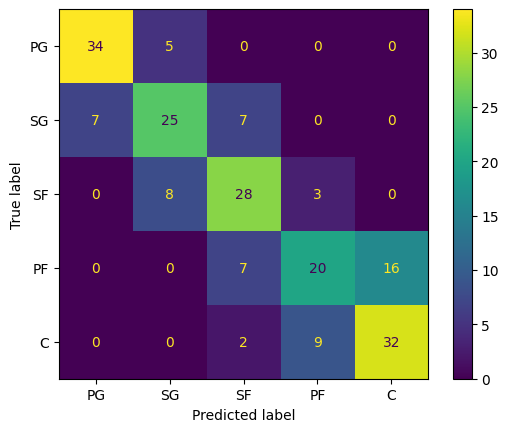

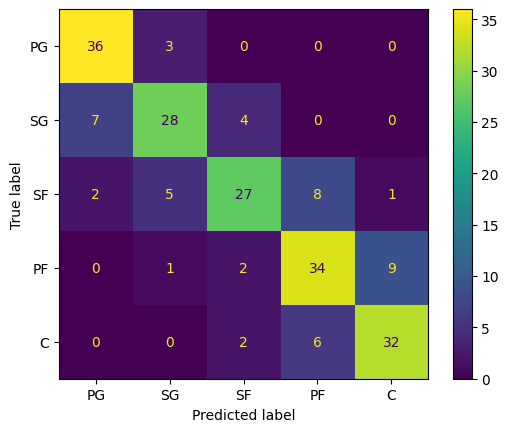

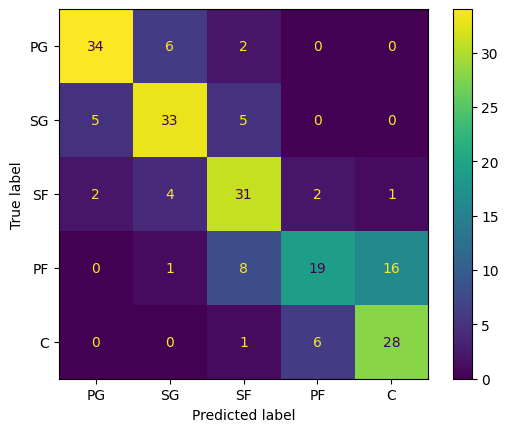

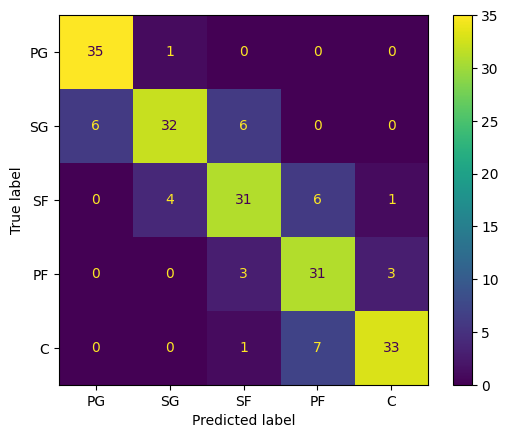

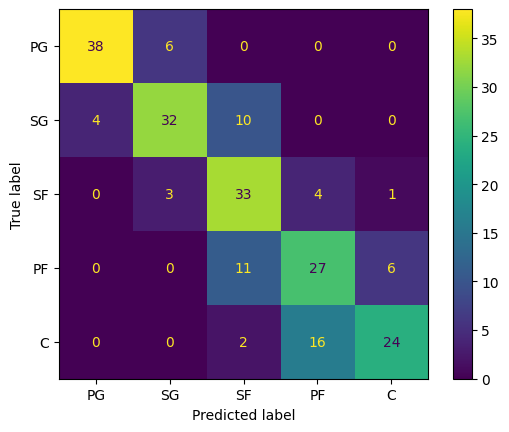

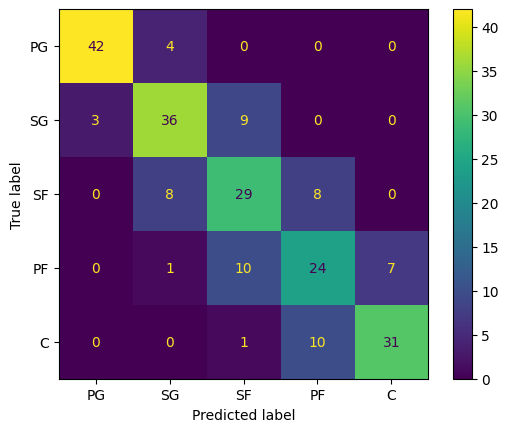

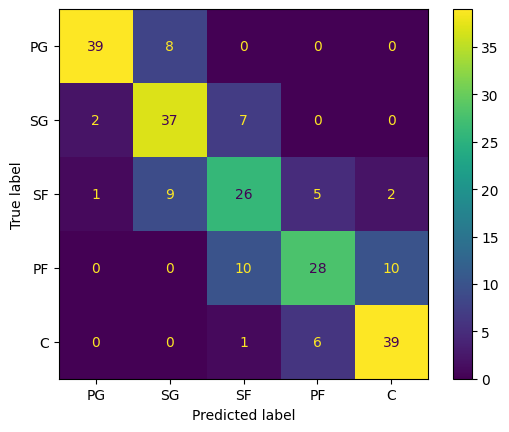

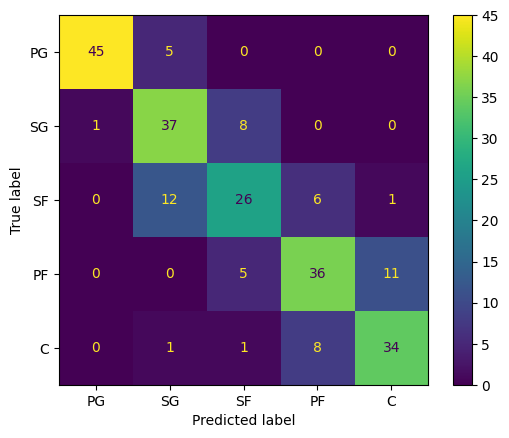

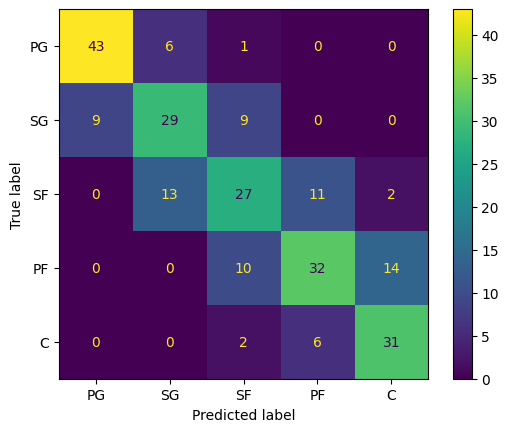

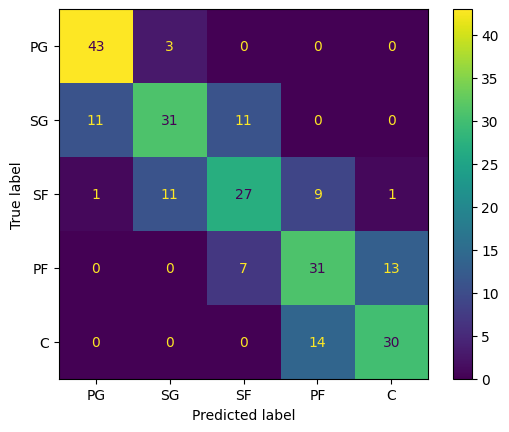

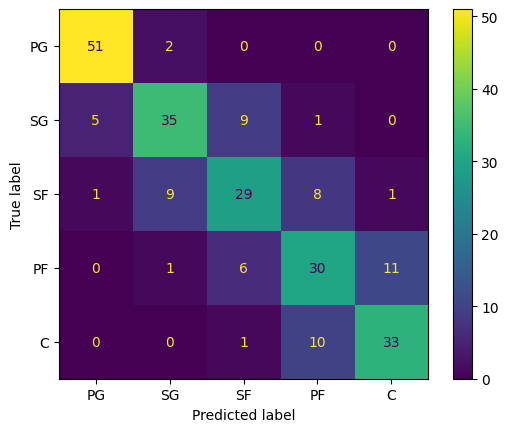

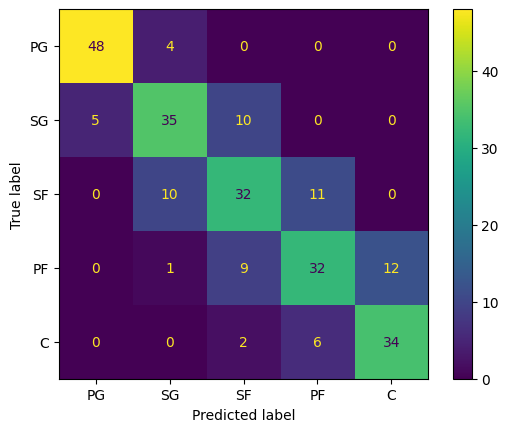

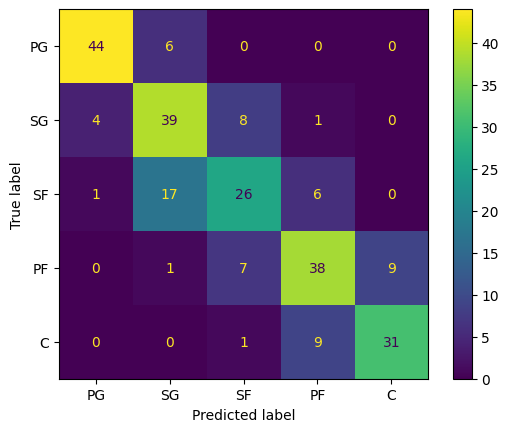

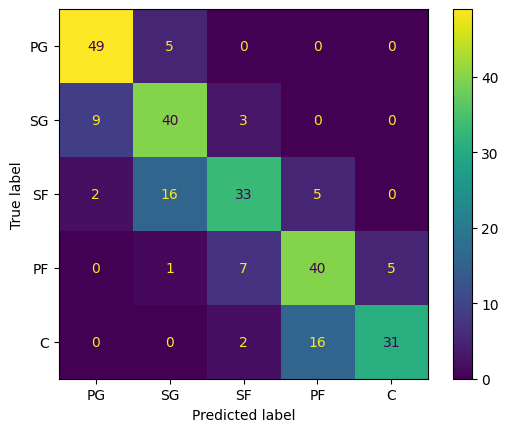

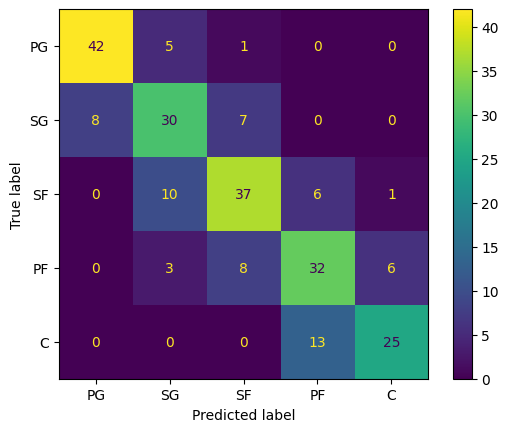

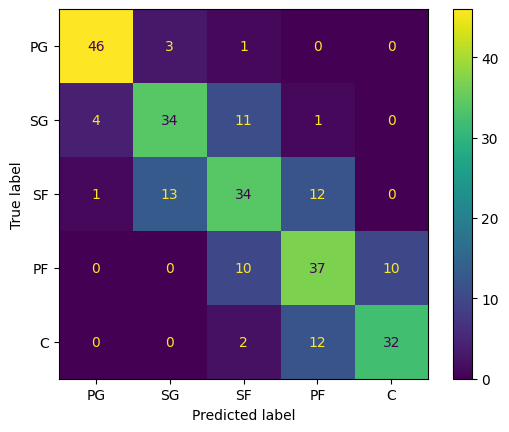

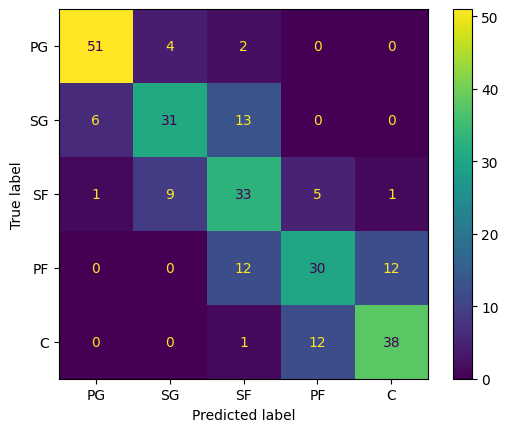

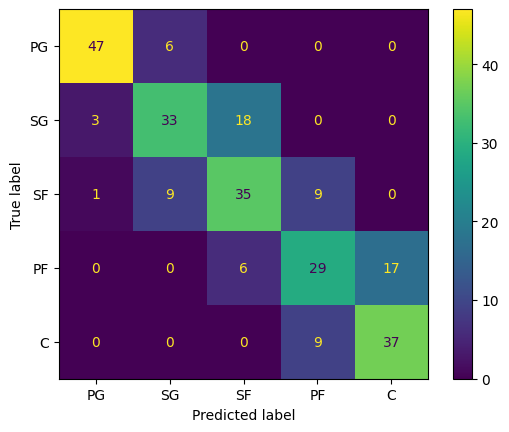

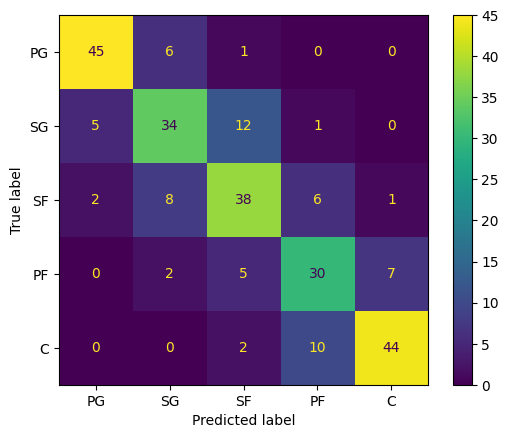

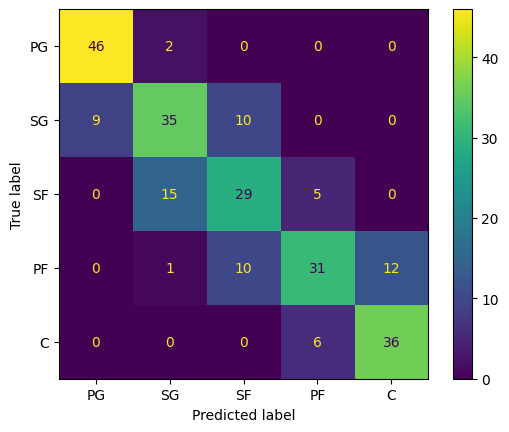

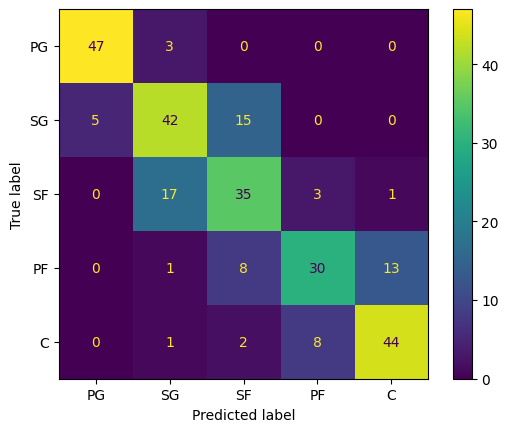

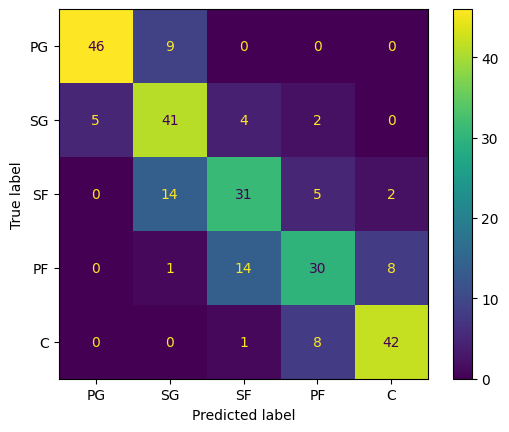

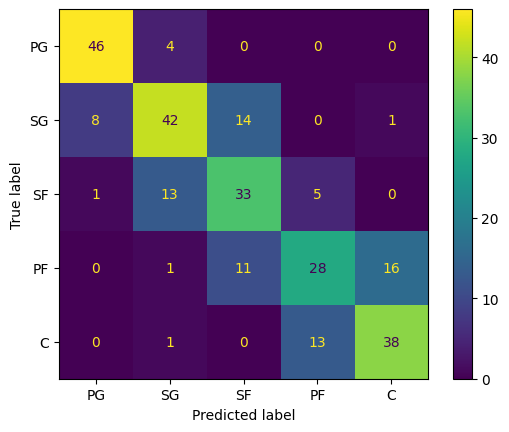

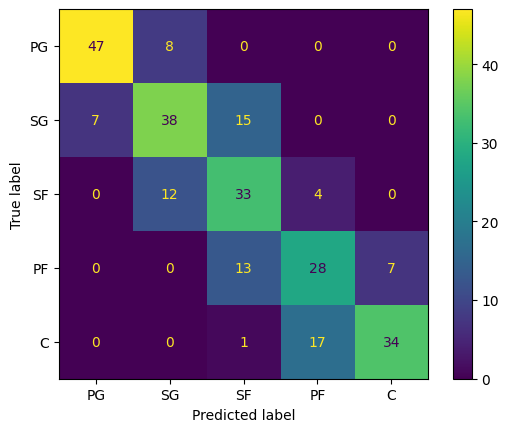

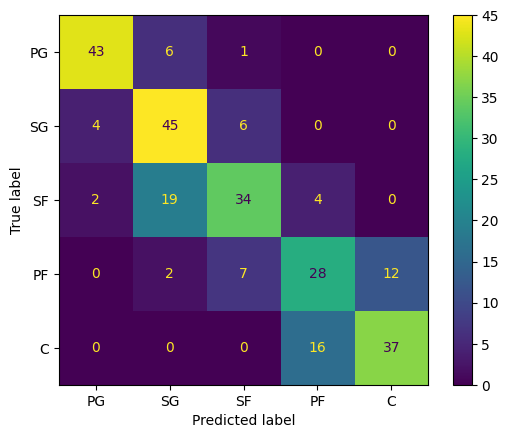

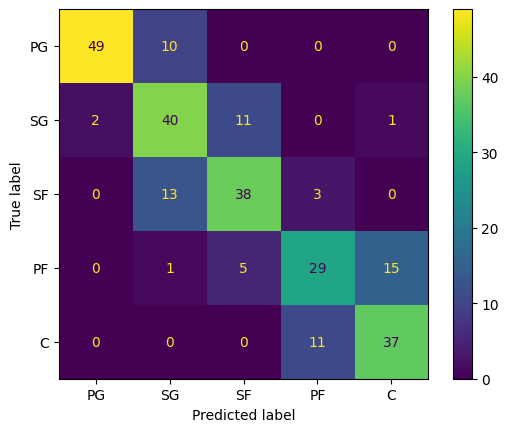

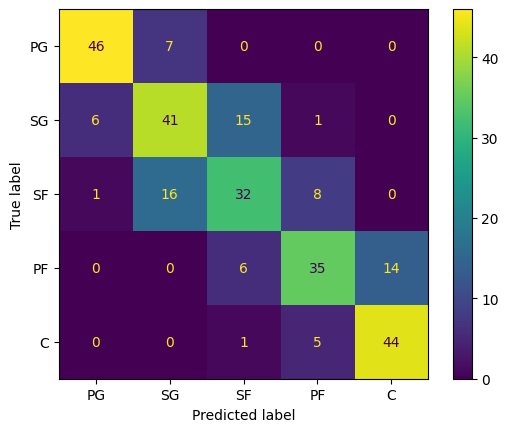

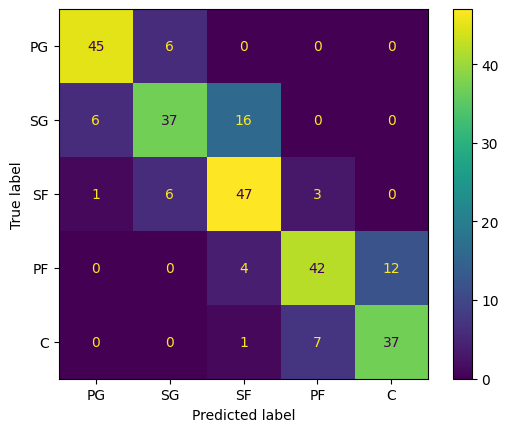

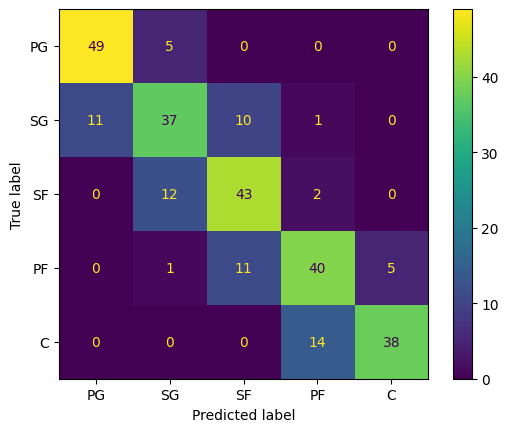

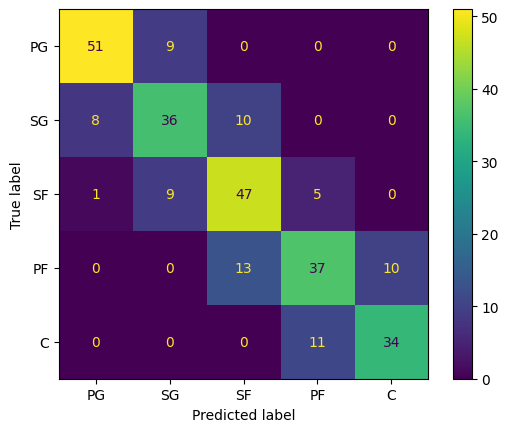

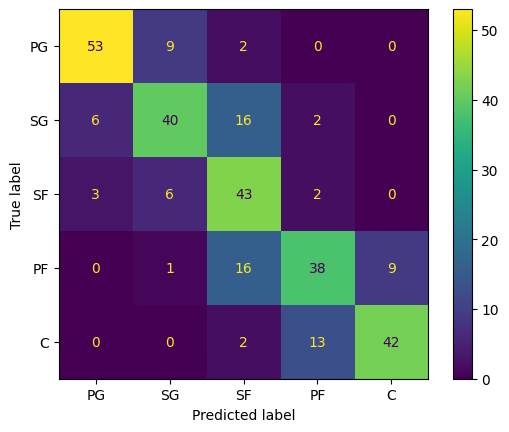

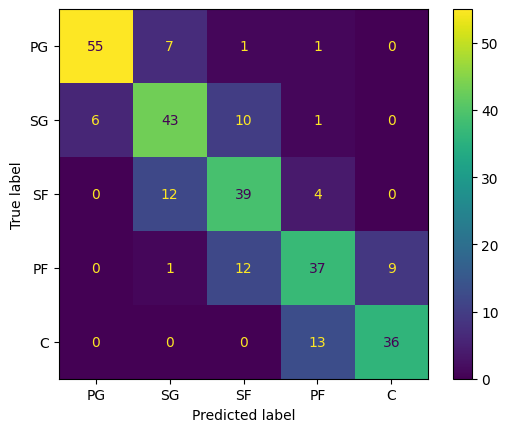

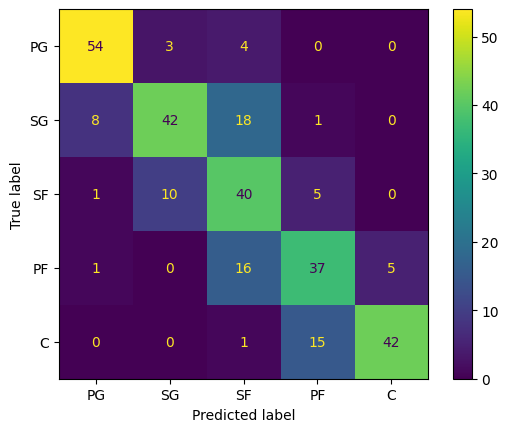

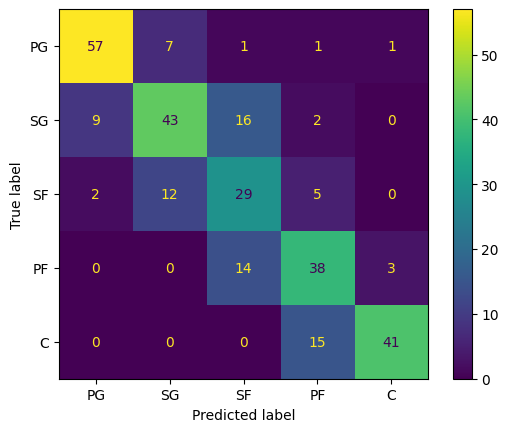

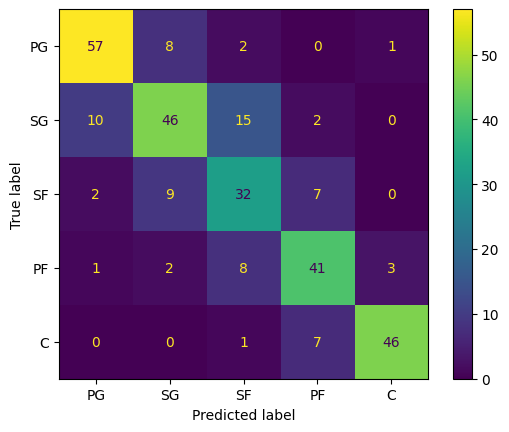

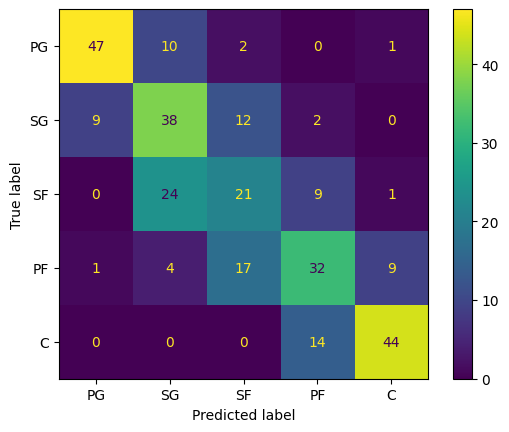

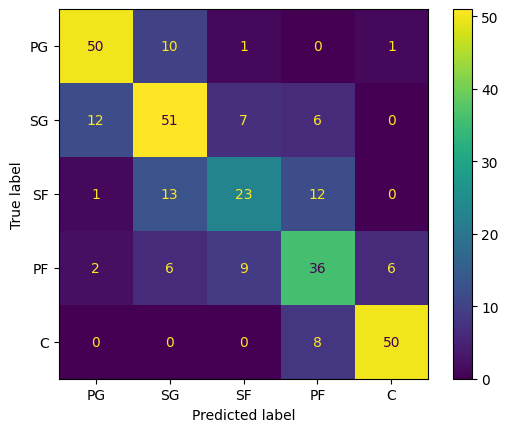

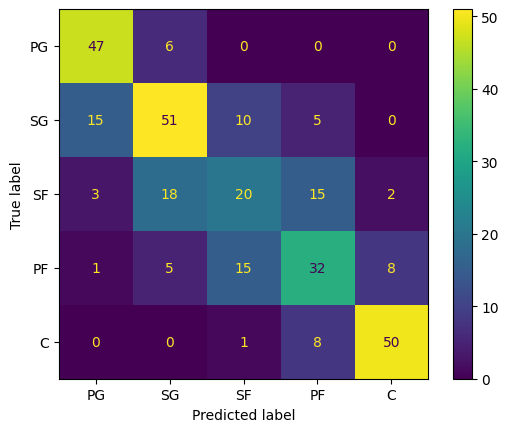

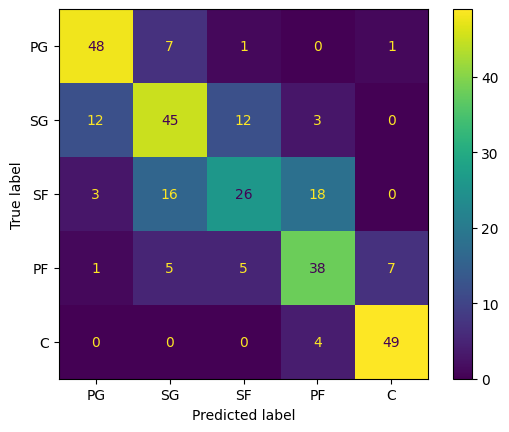

In [14]:
entropies_df, scores, feature_importances = classify_year_by_year(range(1980, 2021), 3)

<Axes: >

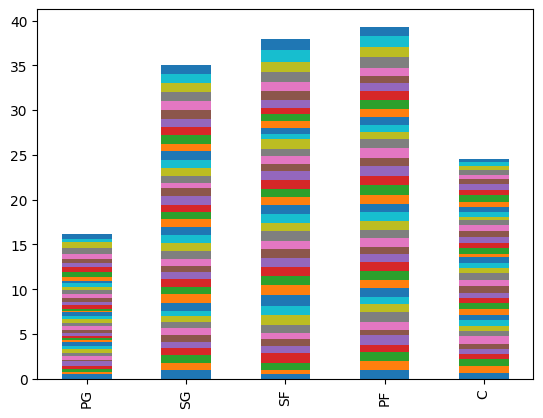

In [15]:
entropies_df.plot(kind='bar', stacked=True, legend=False)

<Axes: >

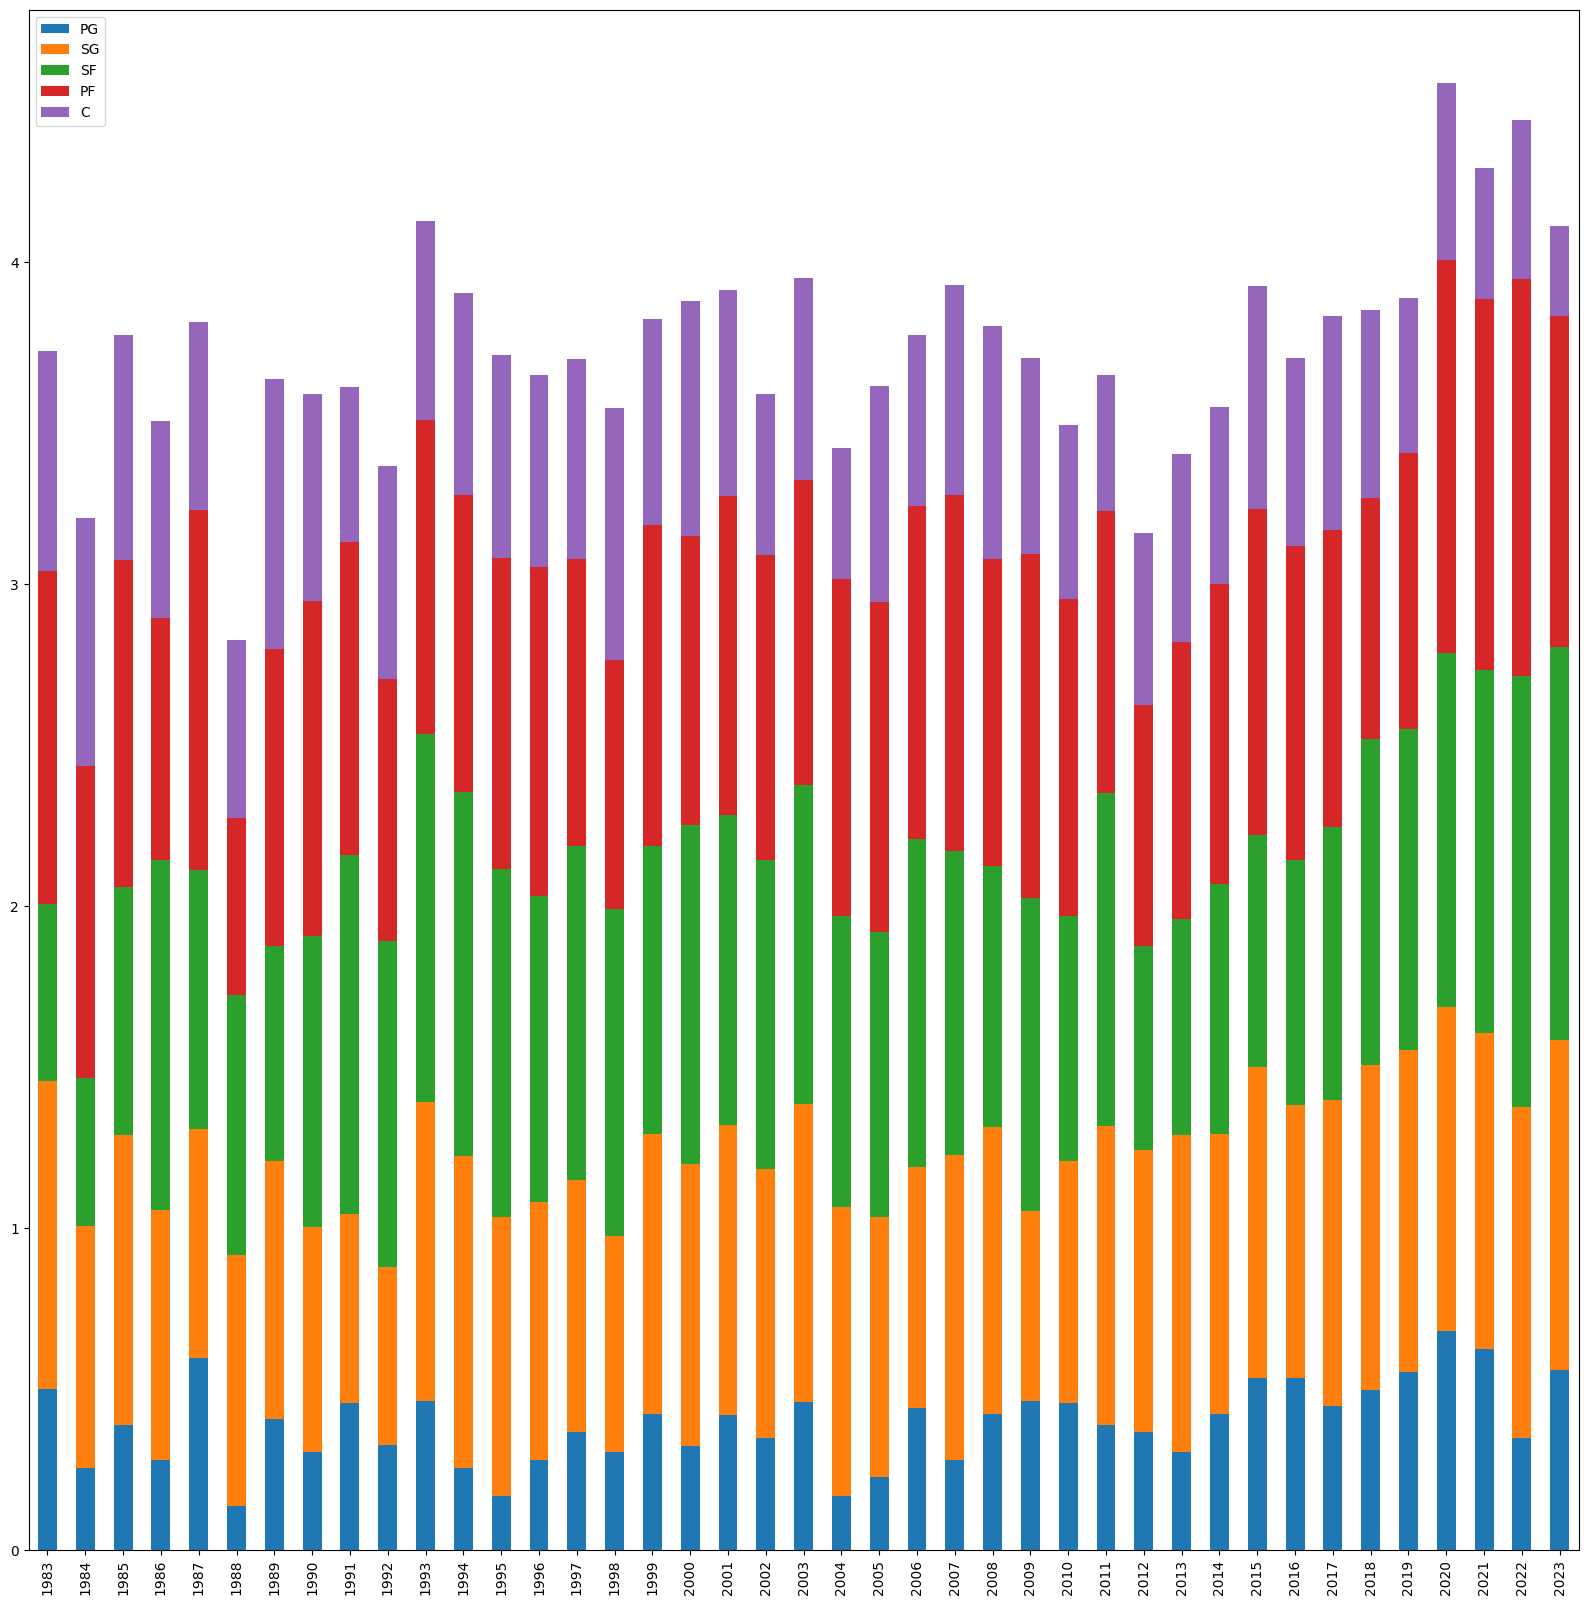

In [16]:
entropies_df.transpose().plot(kind='bar', stacked=True, figsize=(20,20))

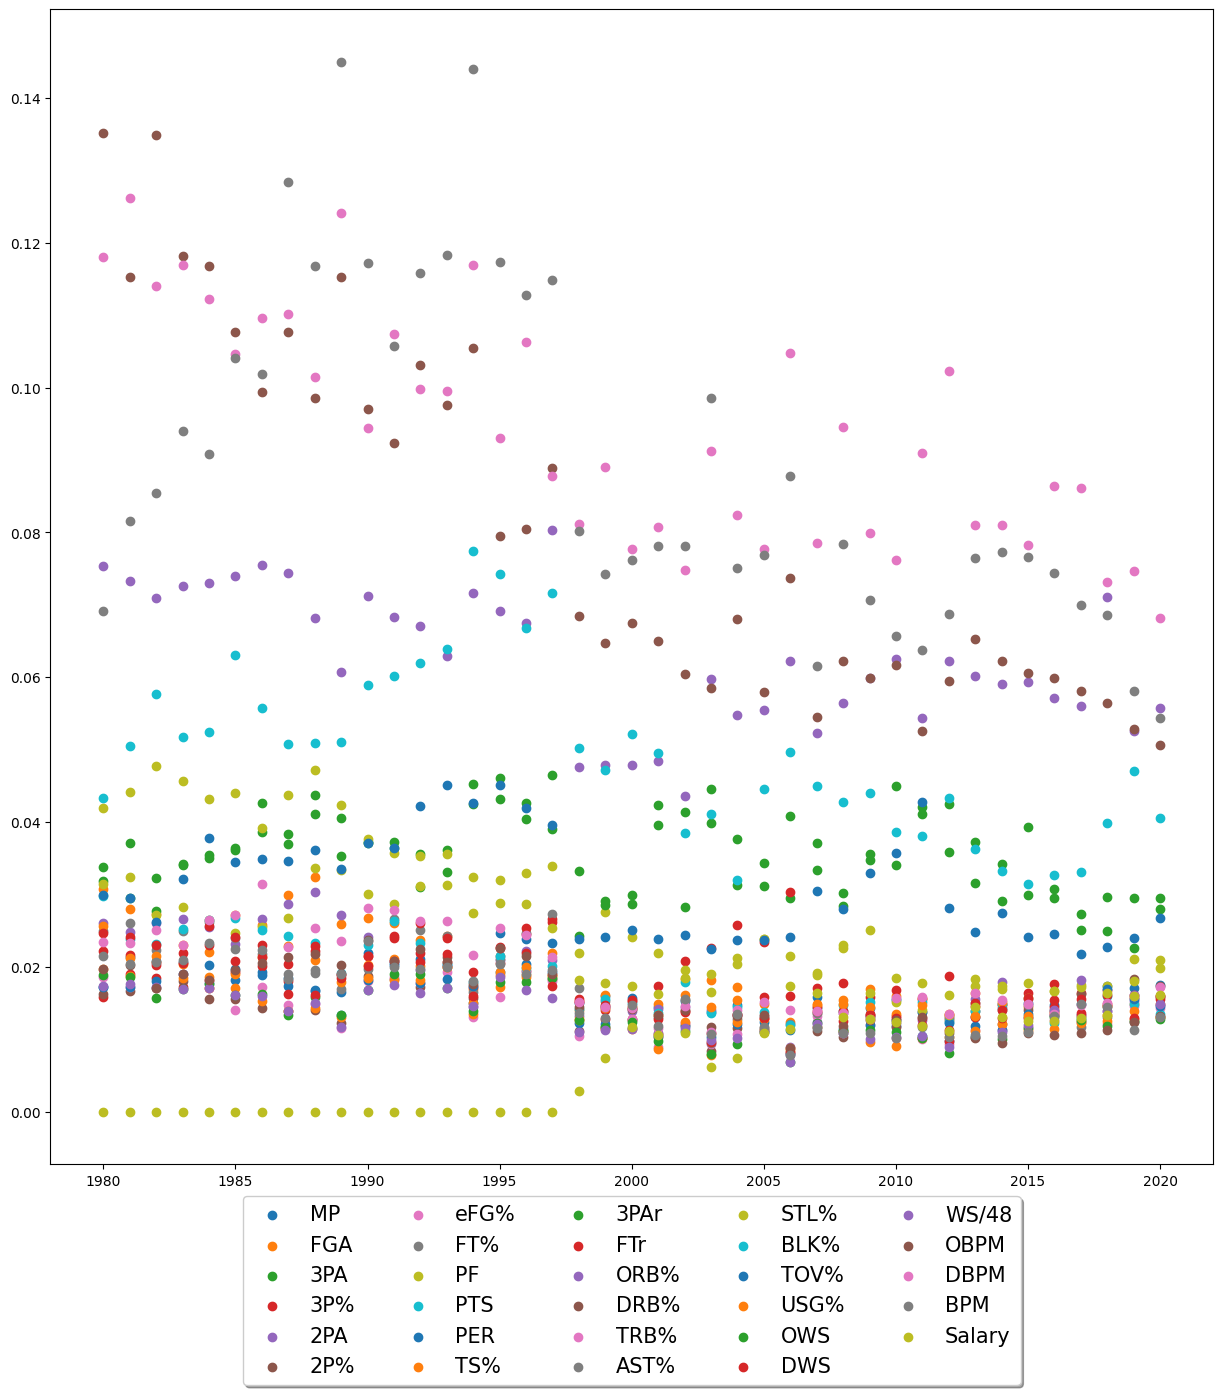

In [17]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=stats_mapper[idx], color=color_mapper[stats_mapper[idx]], alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='lower center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, prop={'size': 15})

plt.show()

# 4 training seasons

C:\Users\mathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


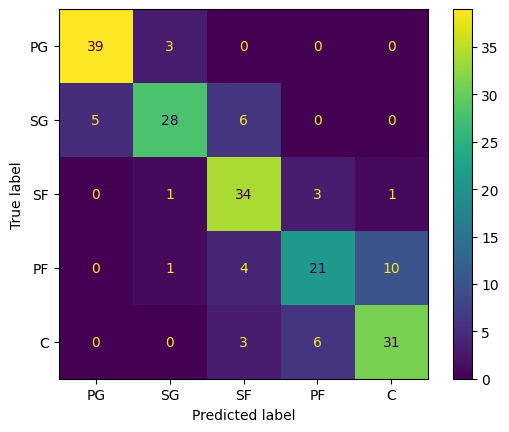

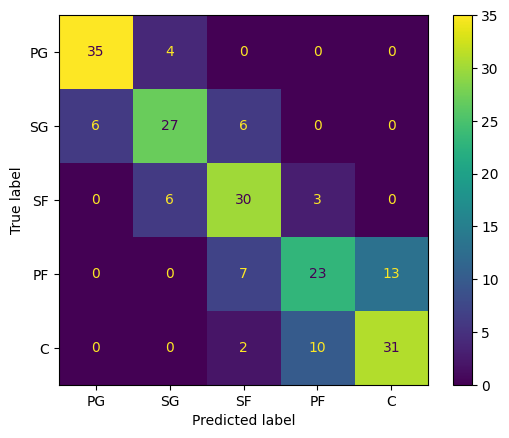

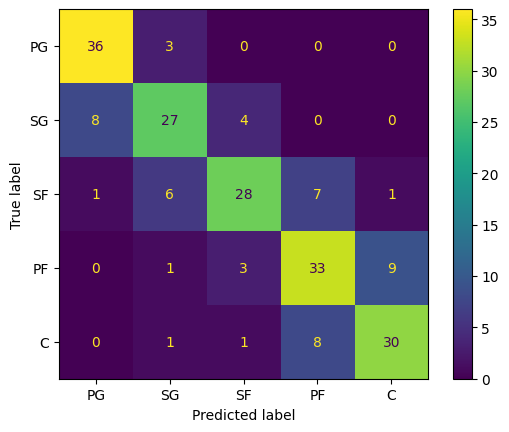

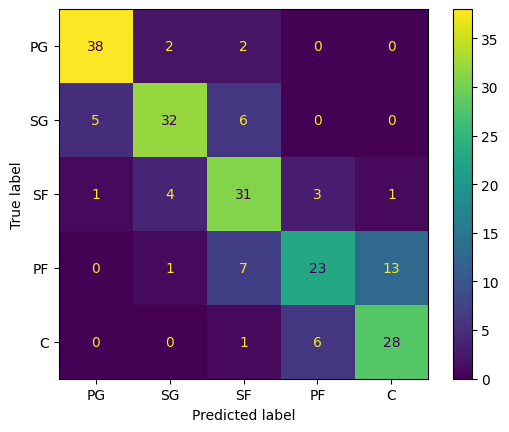

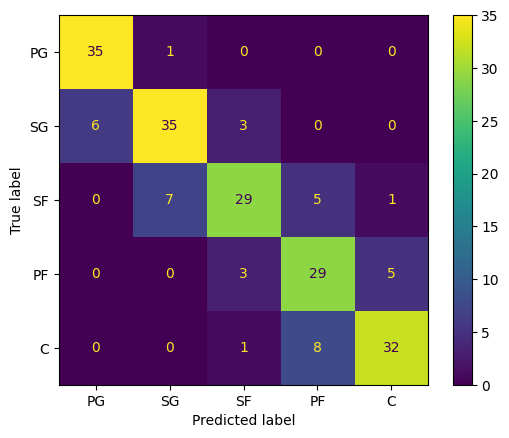

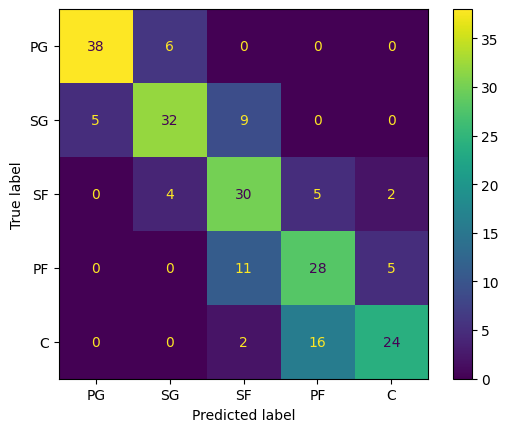

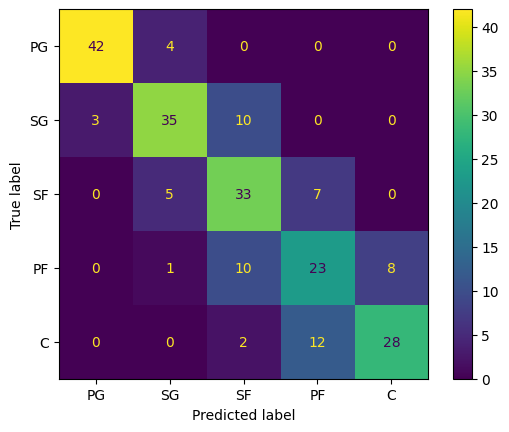

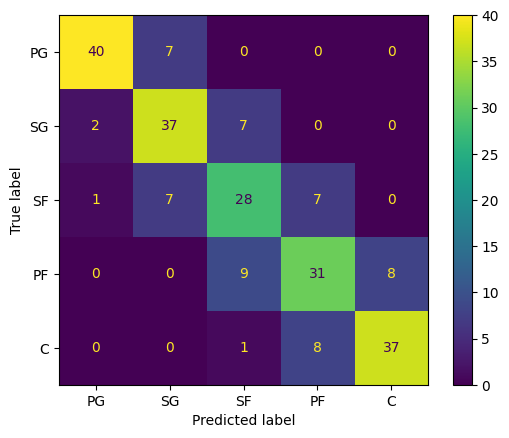

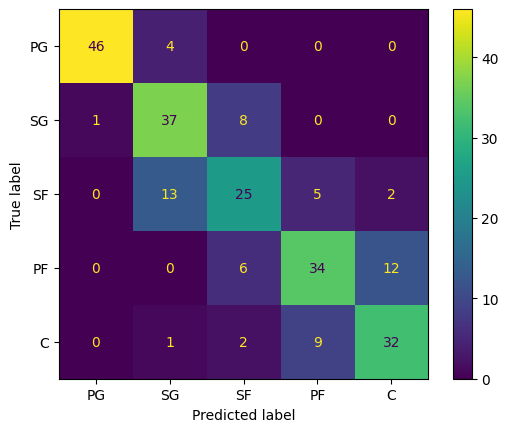

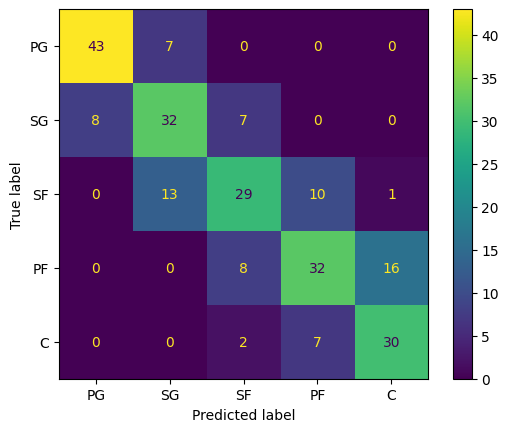

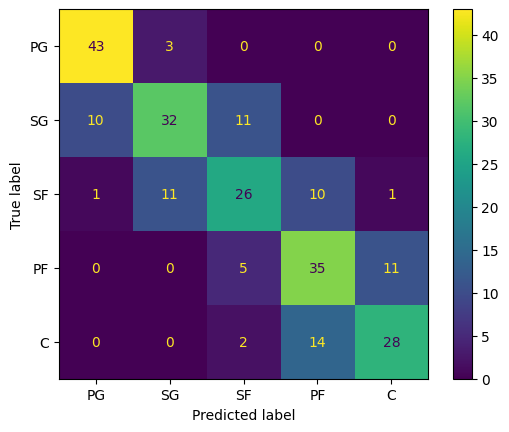

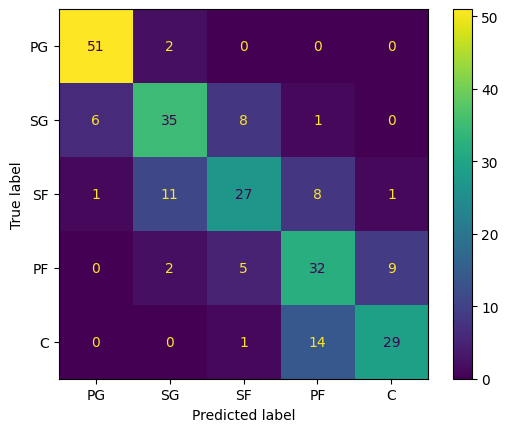

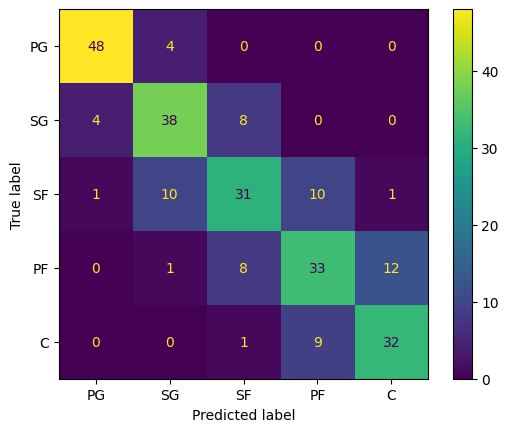

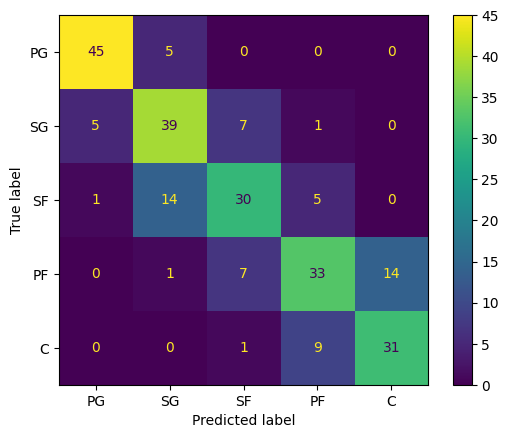

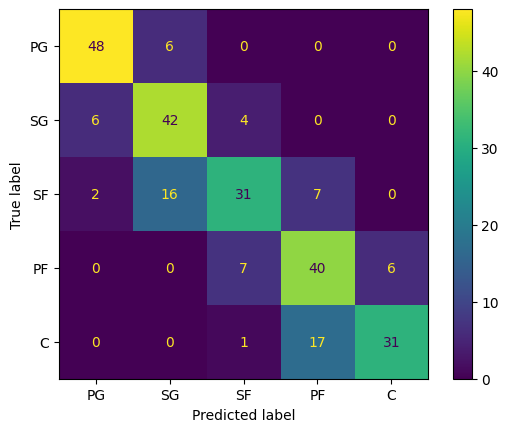

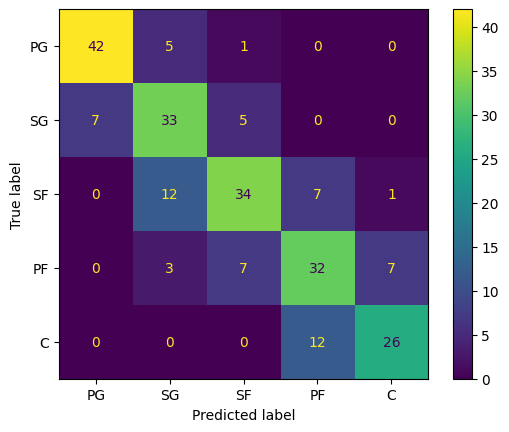

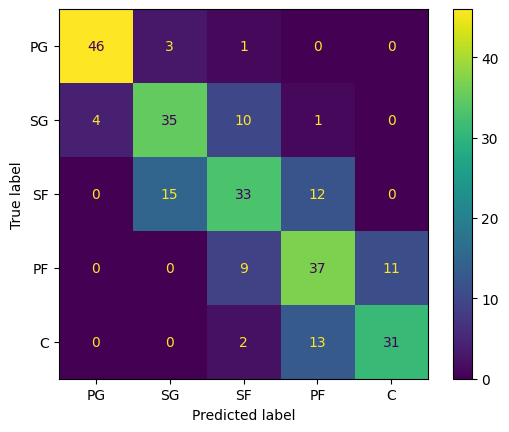

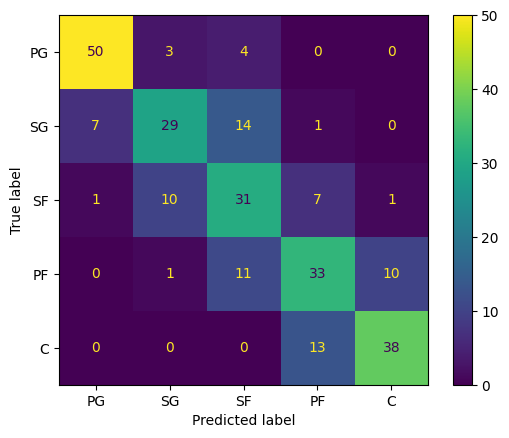

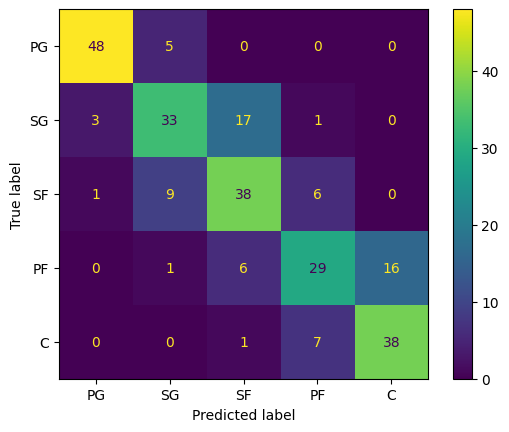

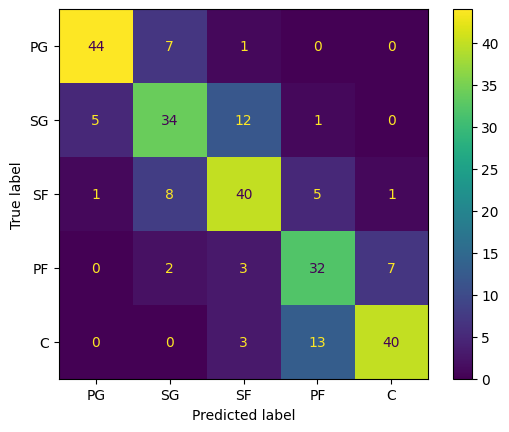

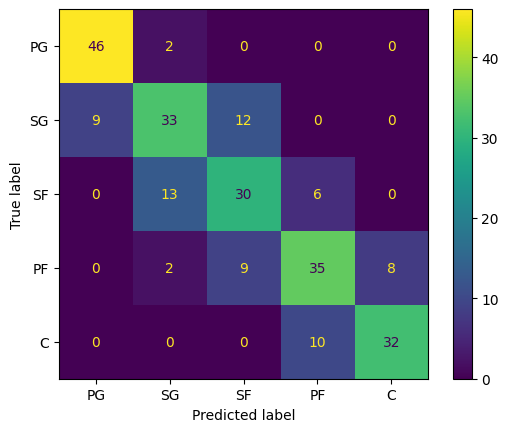

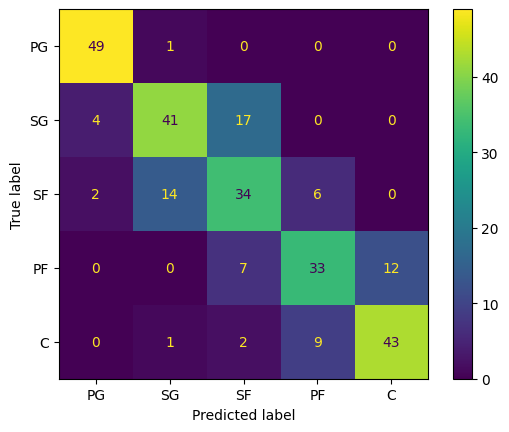

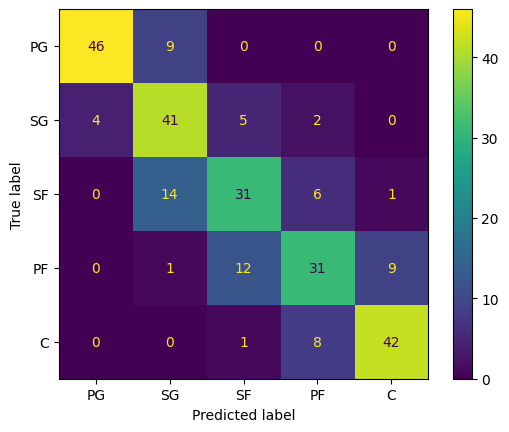

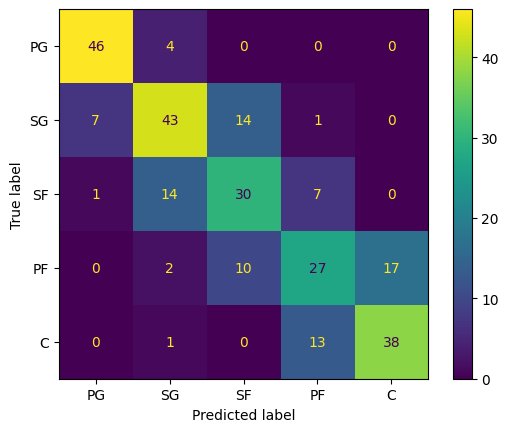

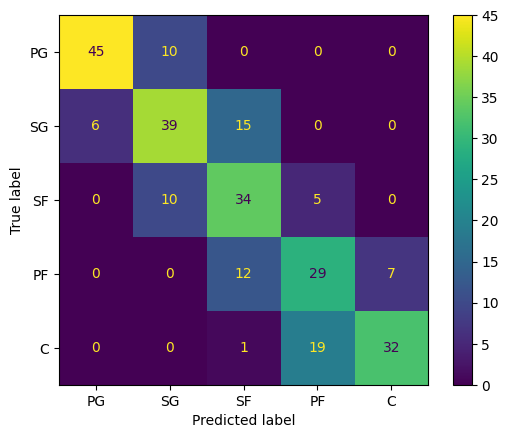

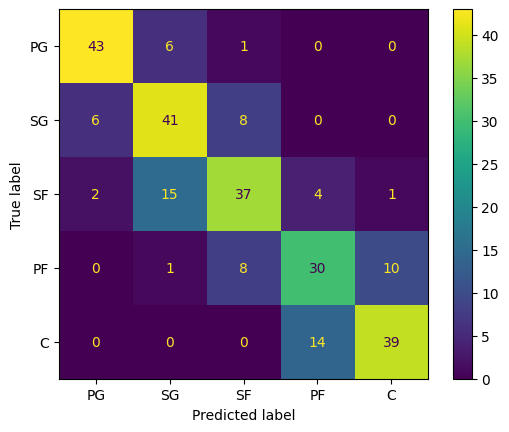

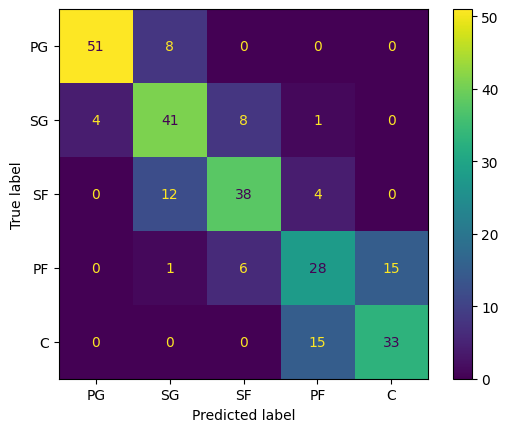

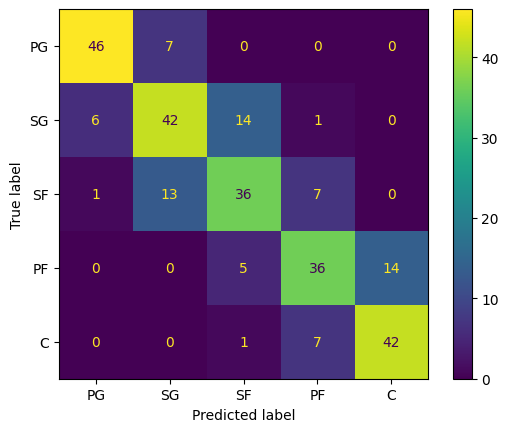

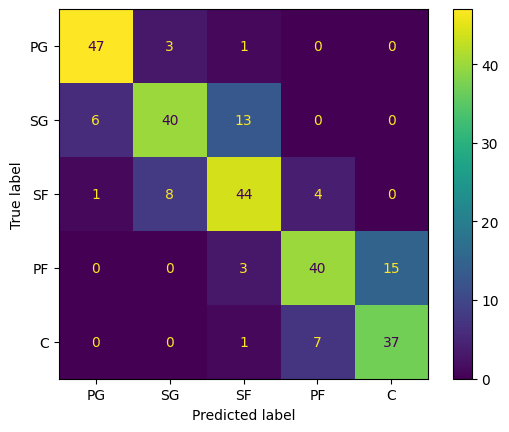

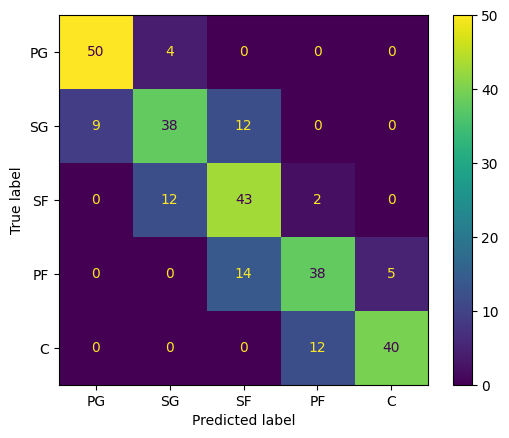

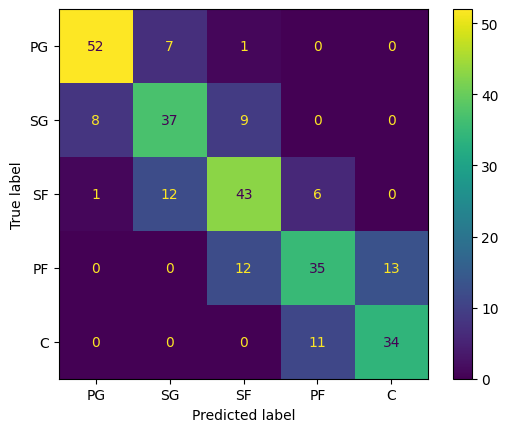

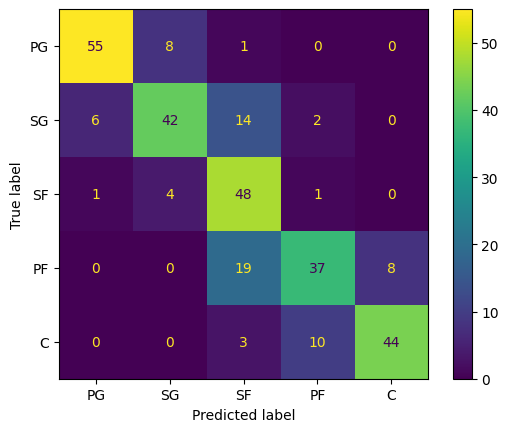

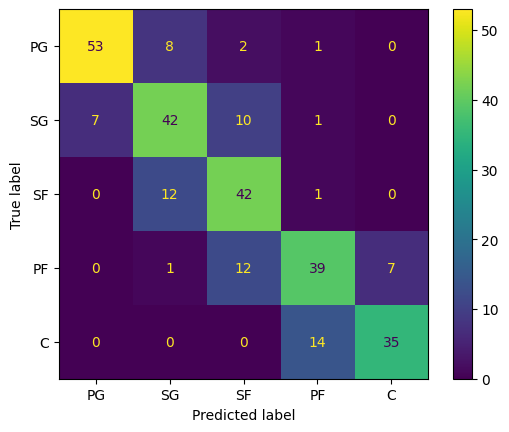

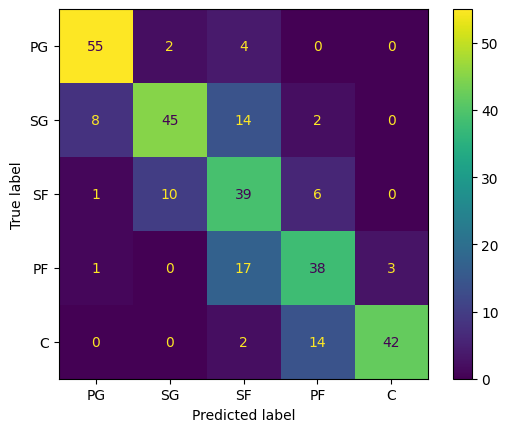

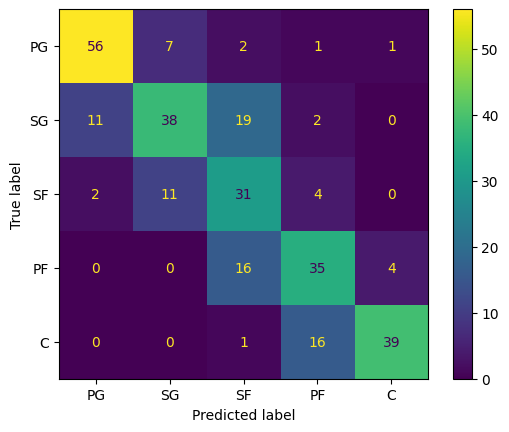

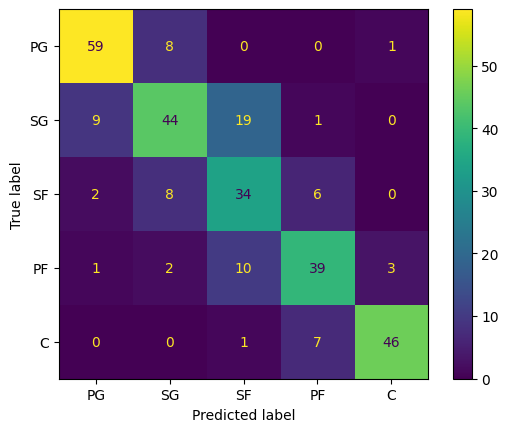

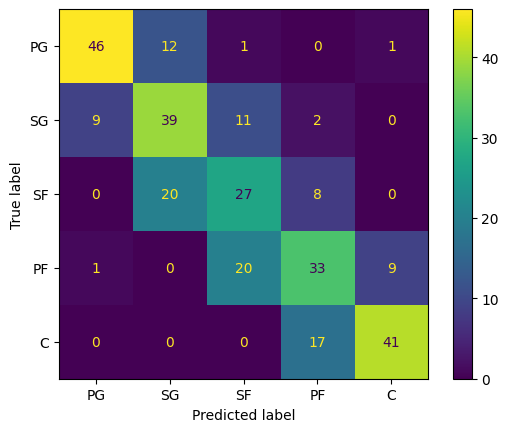

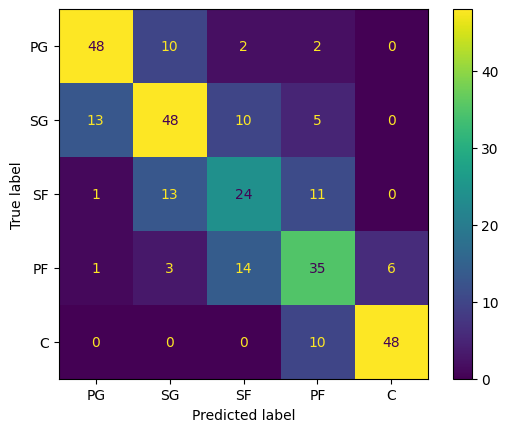

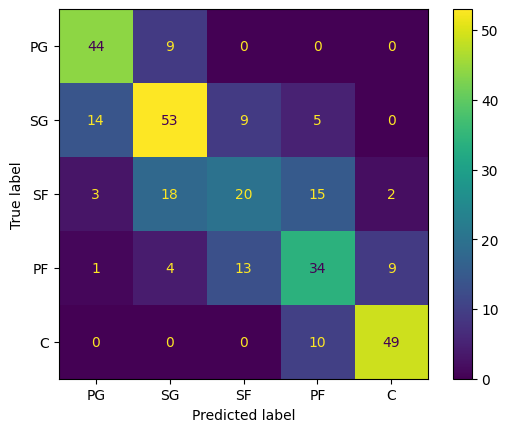

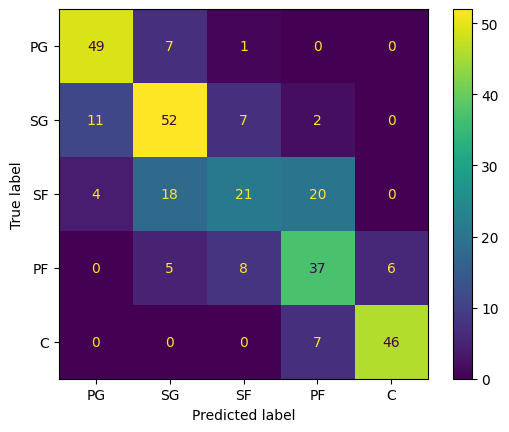

In [18]:
entropies_df, scores, feature_importances = classify_year_by_year(range(1980, 2020))

<Axes: >

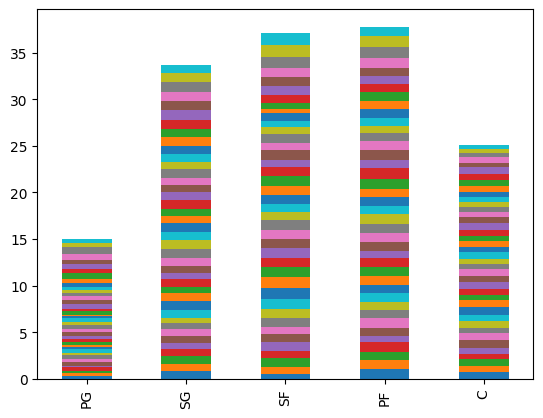

In [19]:
entropies_df.plot(kind='bar', stacked=True, legend=False)

<Axes: >

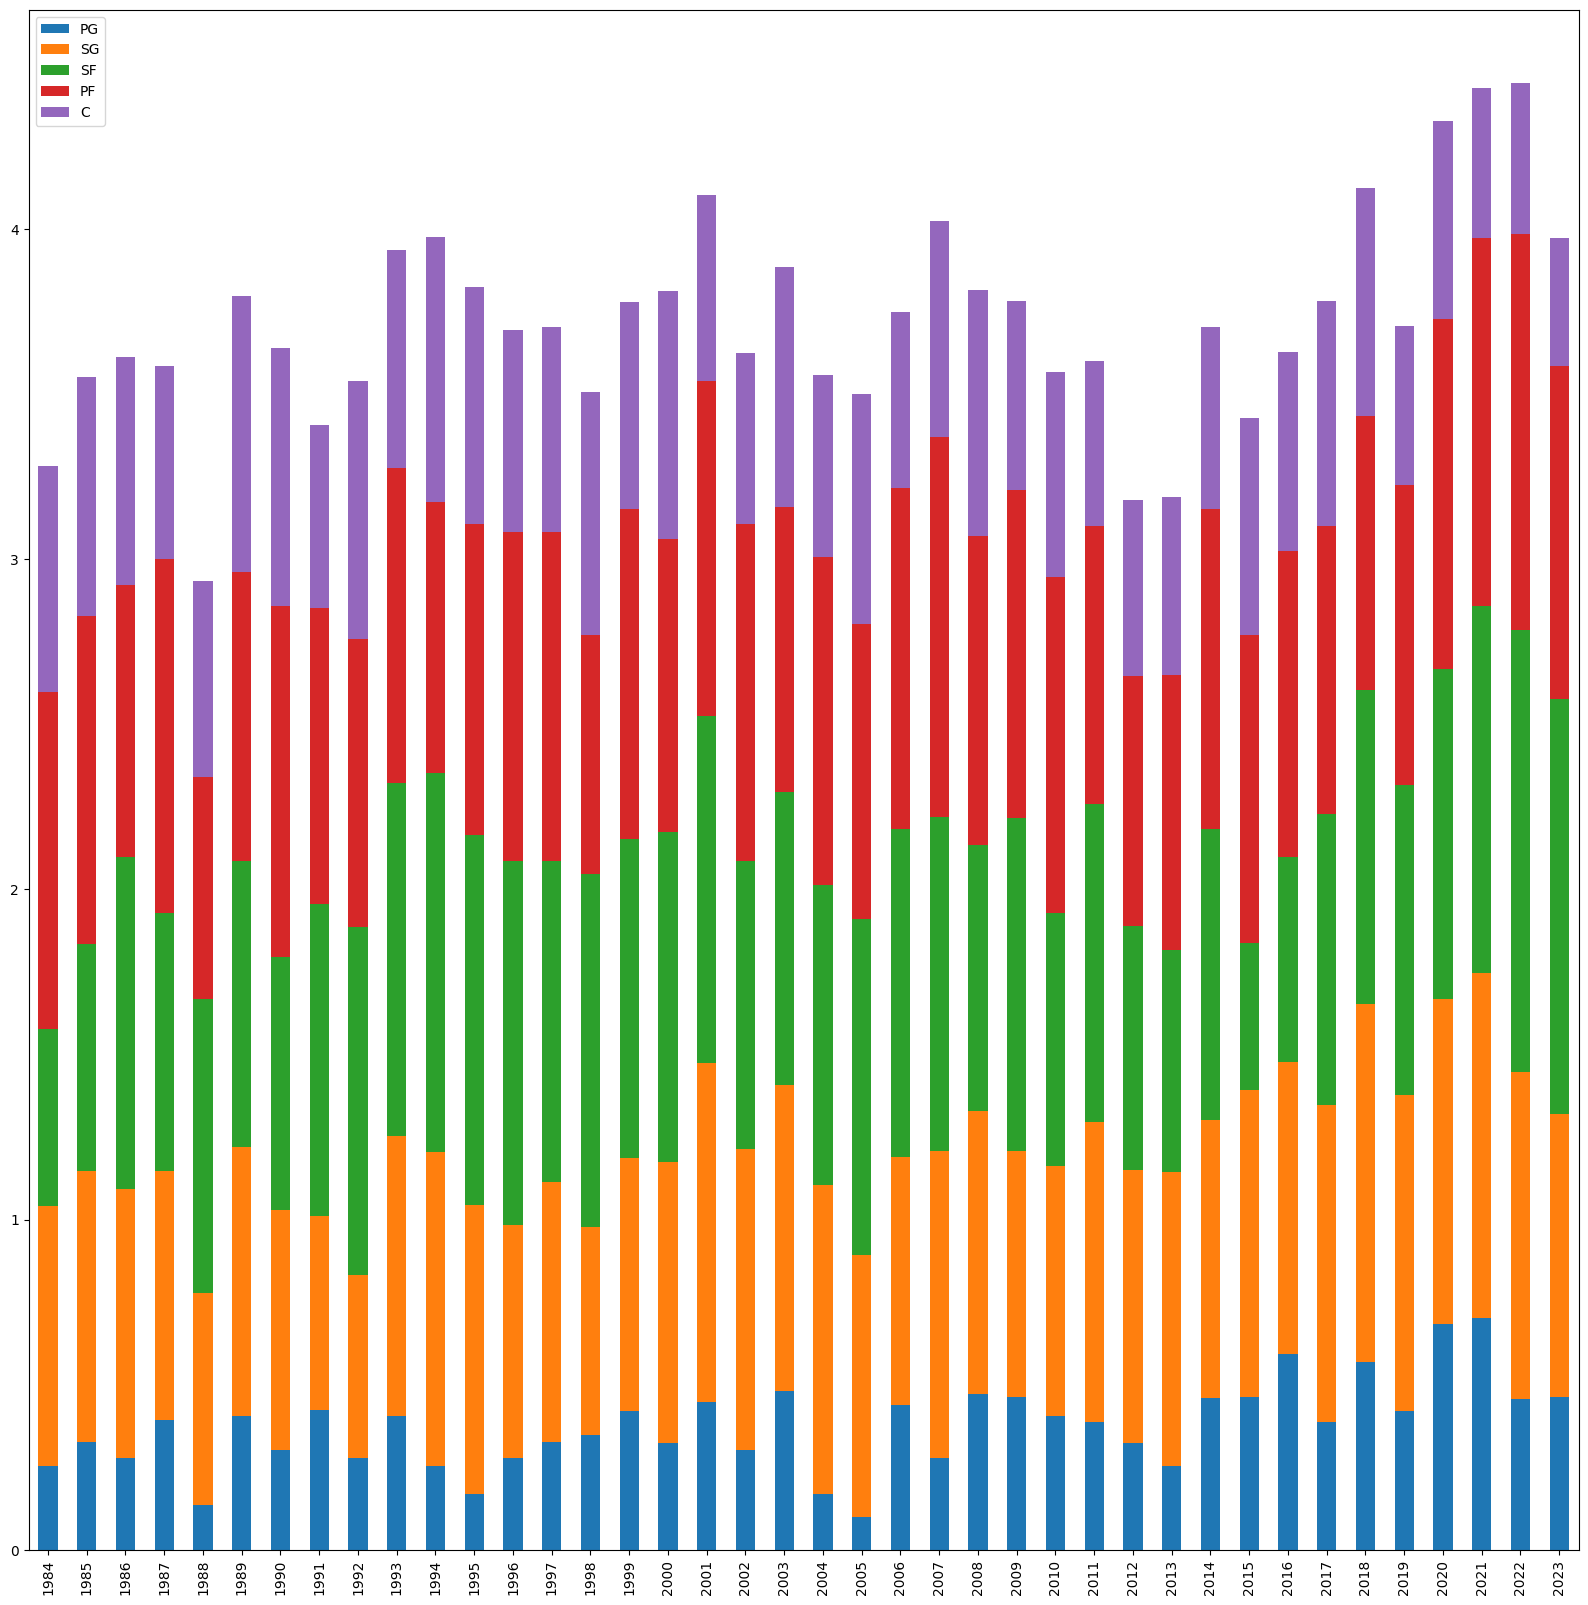

In [20]:
entropies_df.transpose().plot(kind='bar', stacked=True, figsize=(20,20))

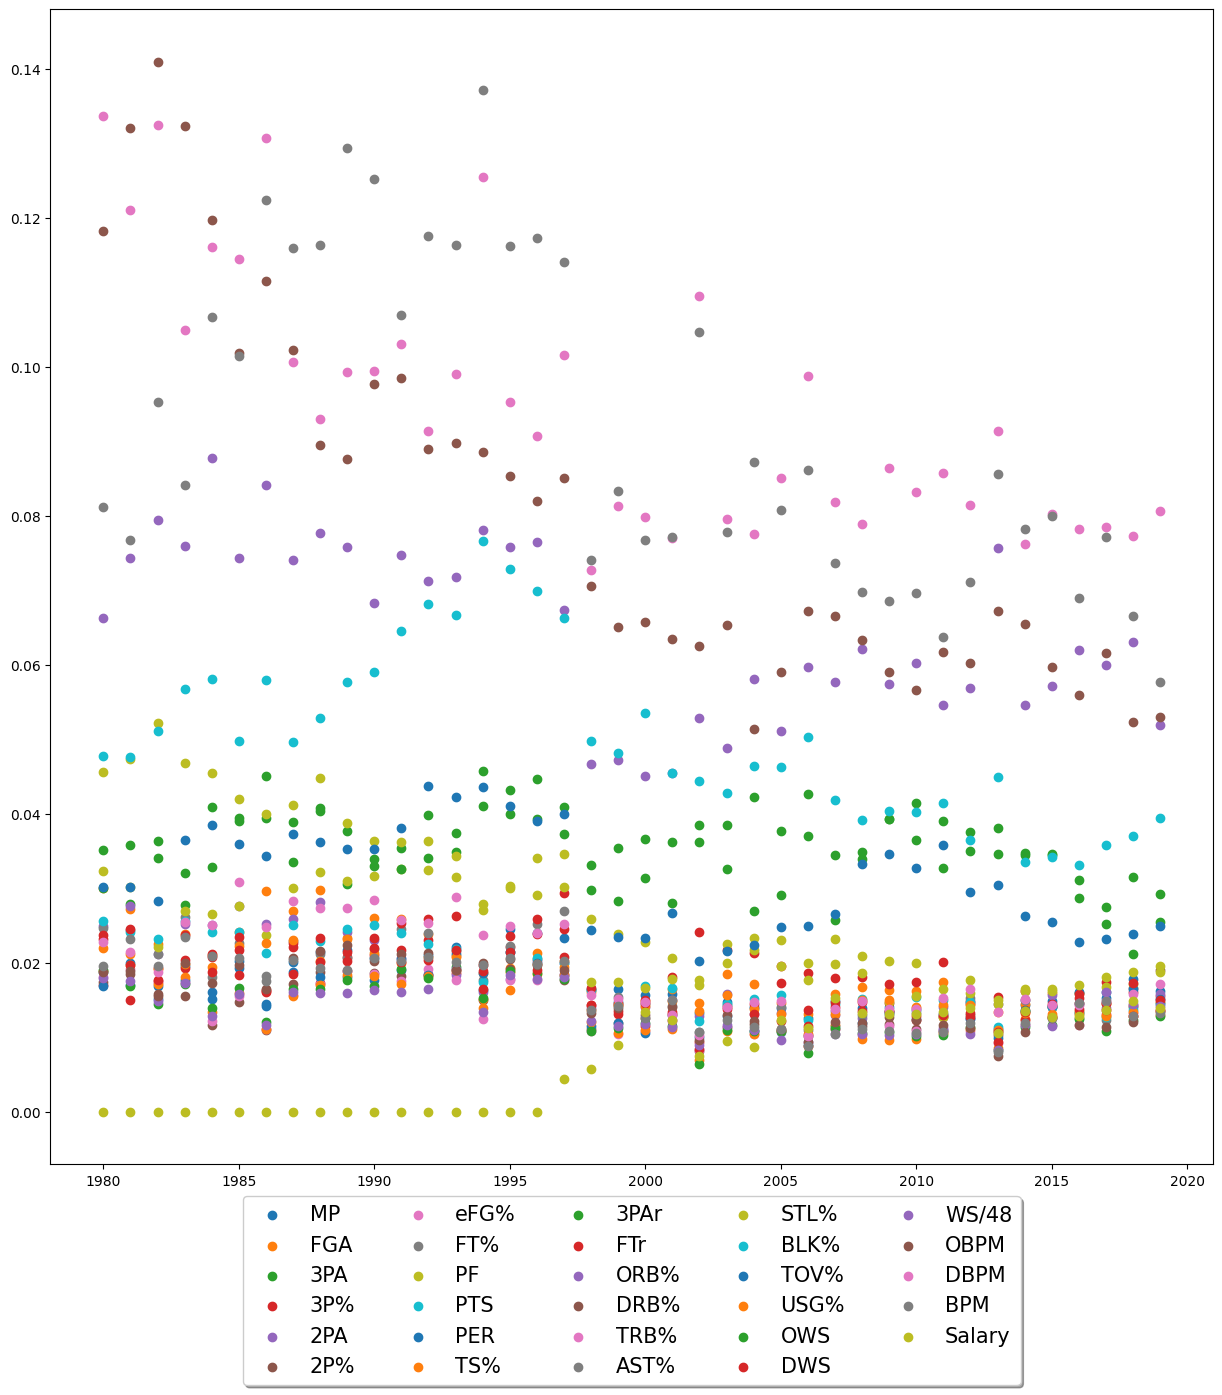

In [21]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=idx)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5, prop={'size': 15})

plt.show()

# 5 training seasons

C:\Users\mathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


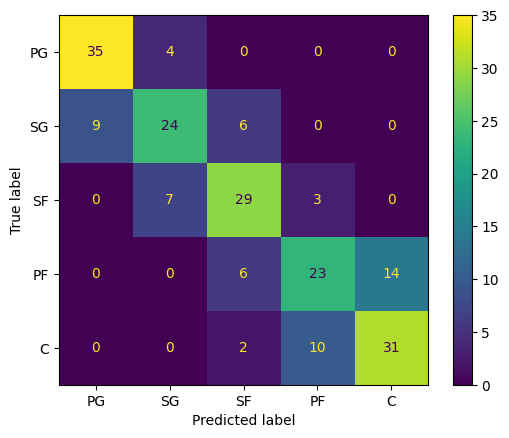

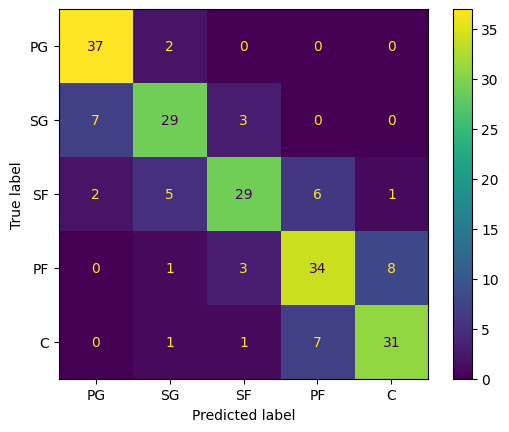

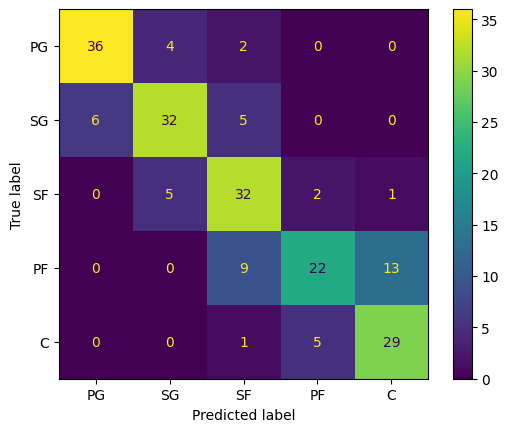

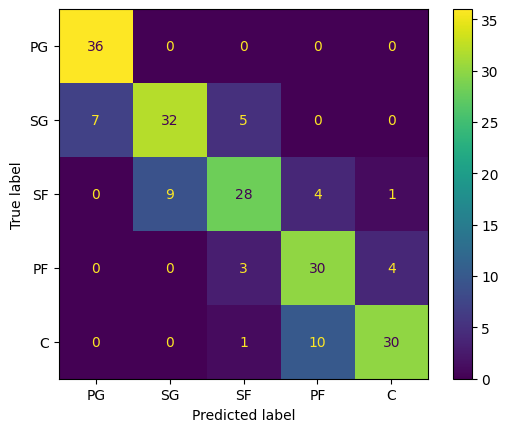

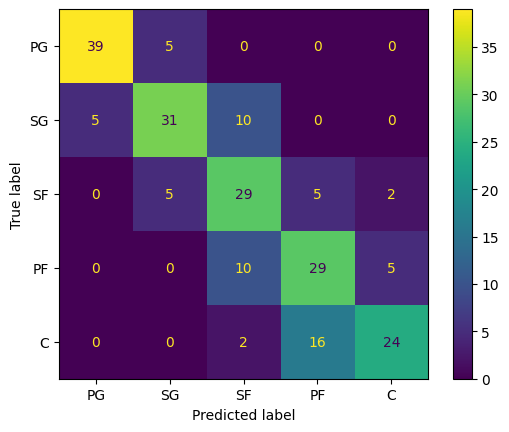

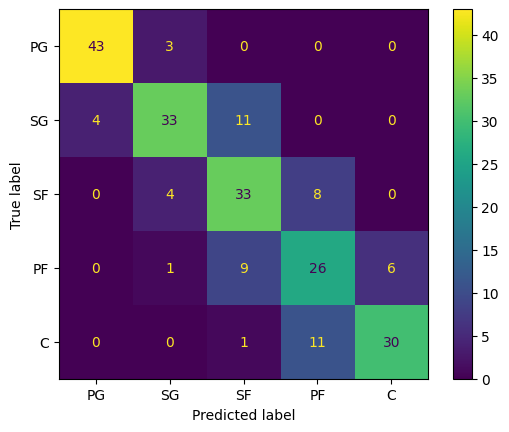

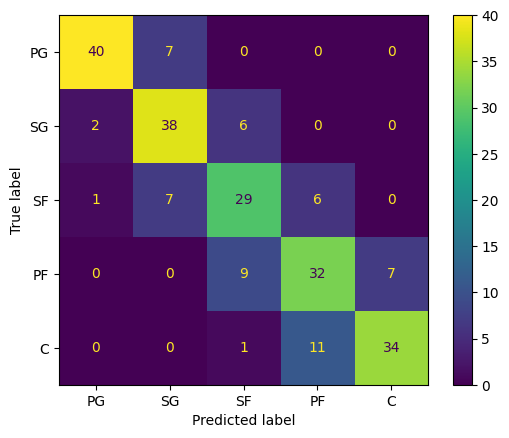

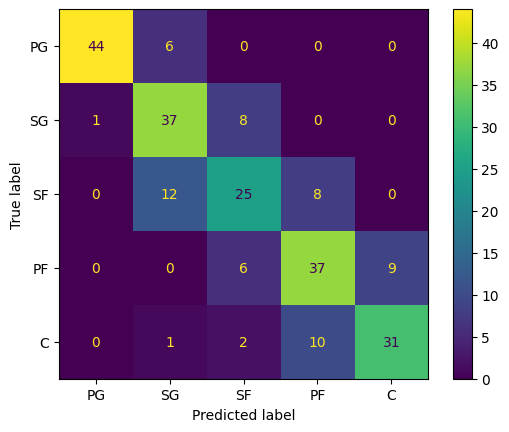

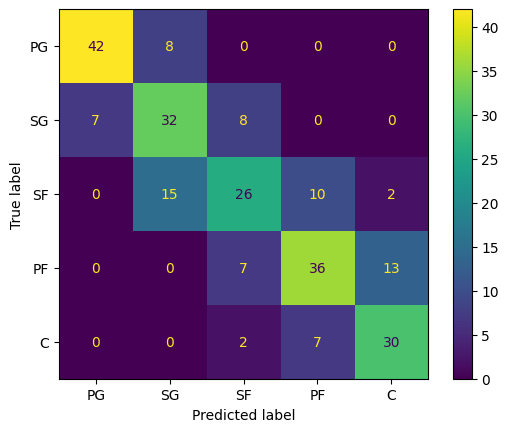

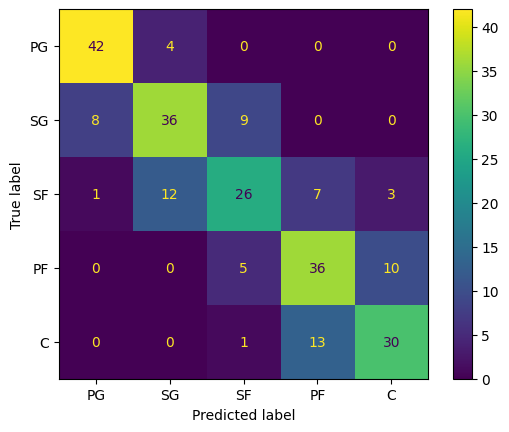

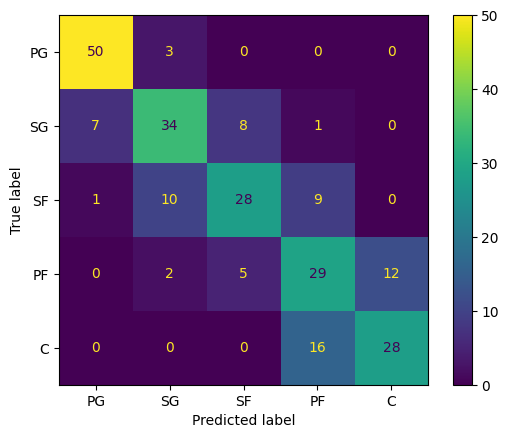

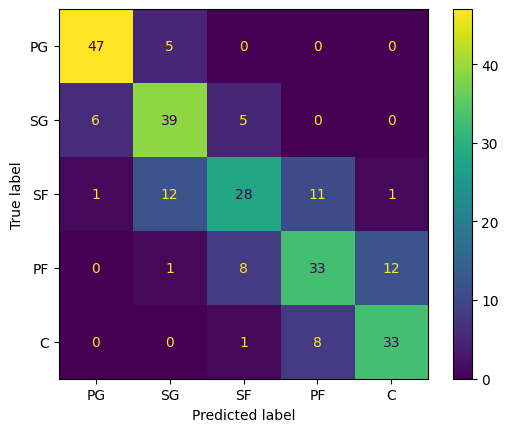

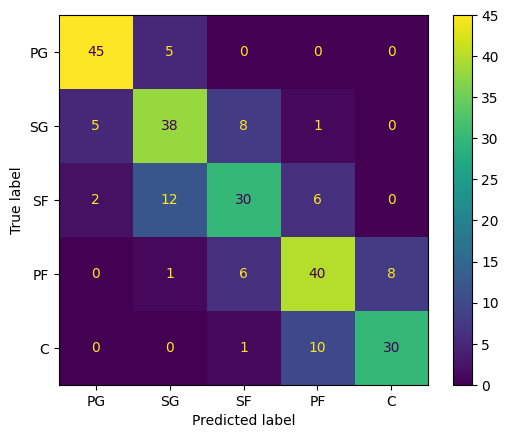

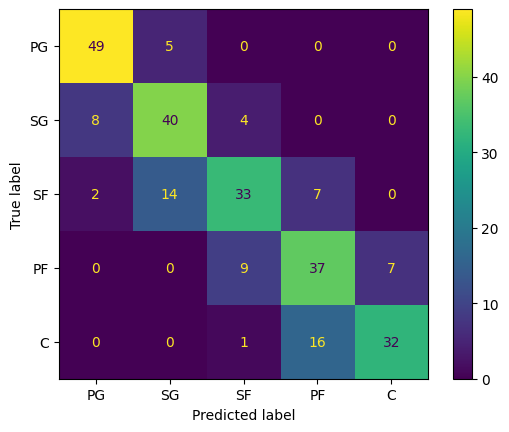

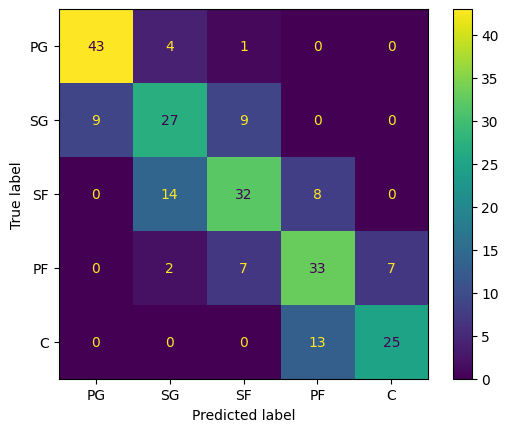

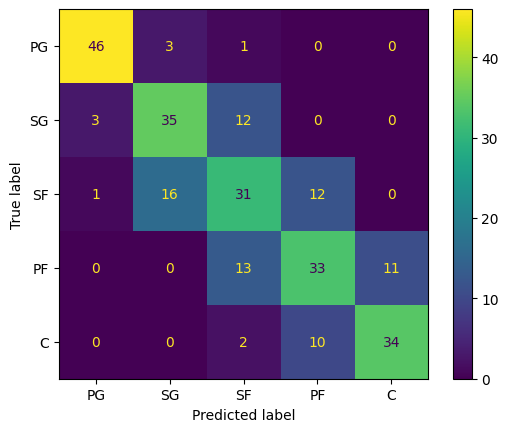

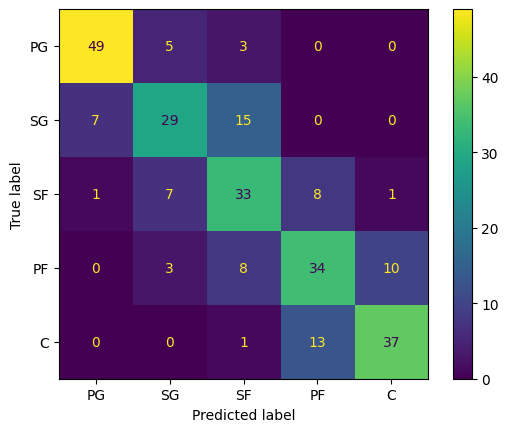

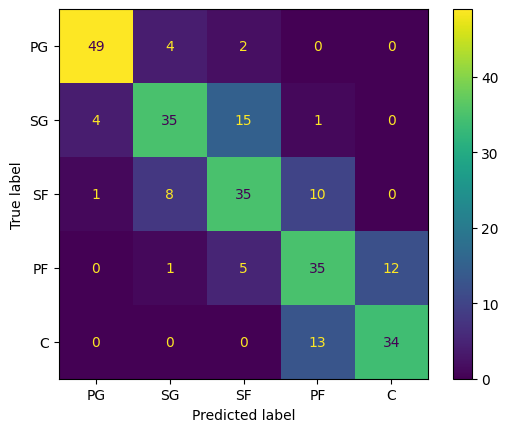

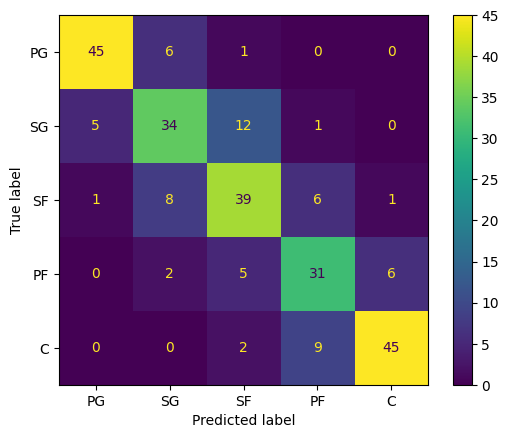

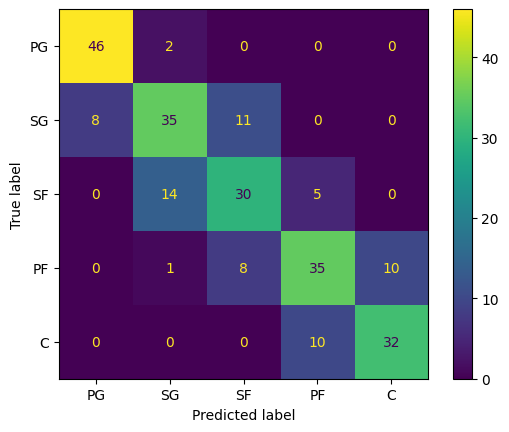

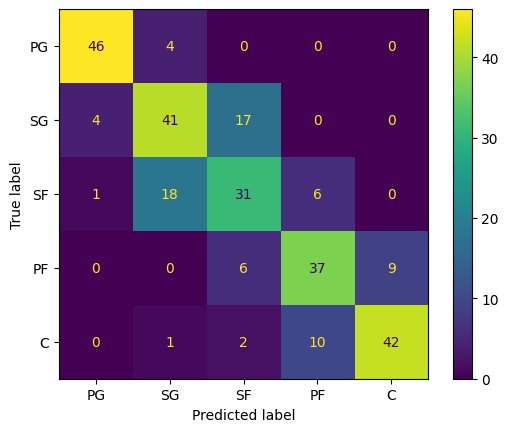

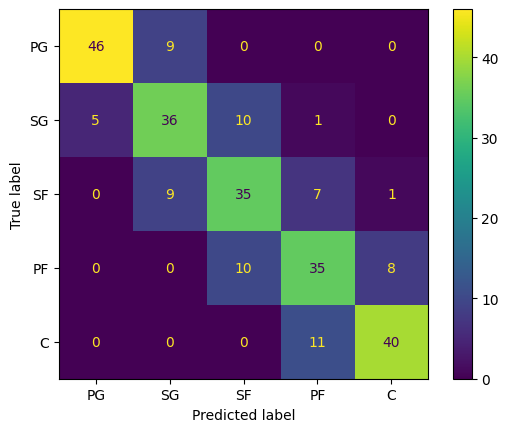

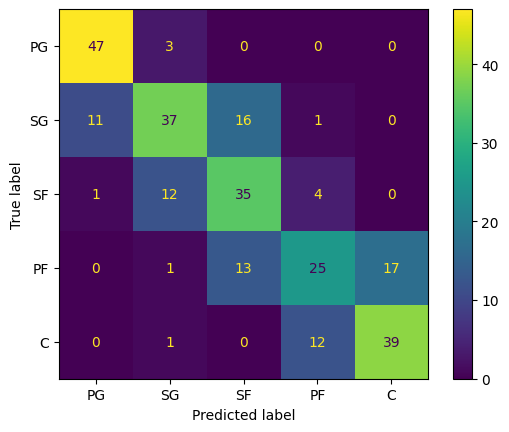

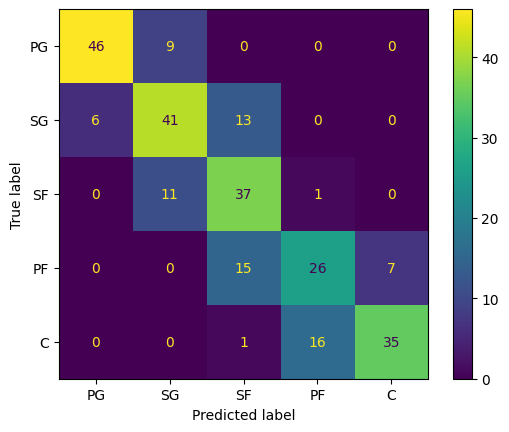

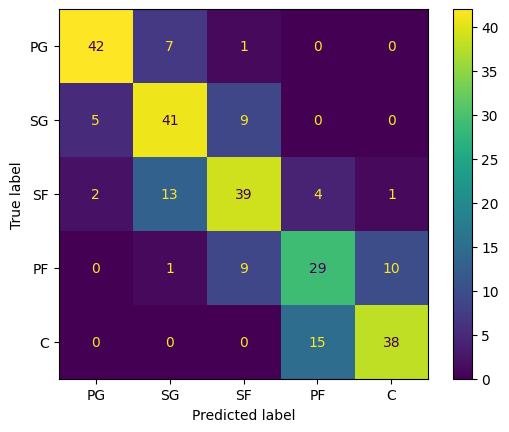

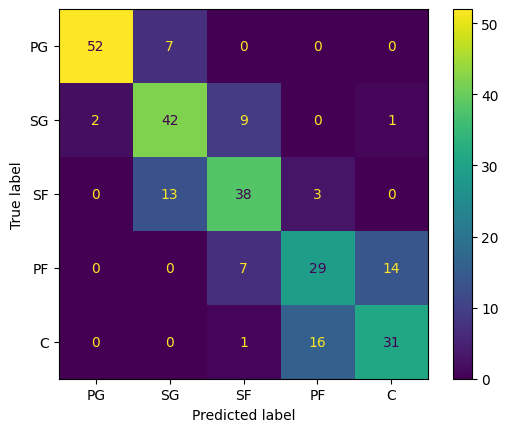

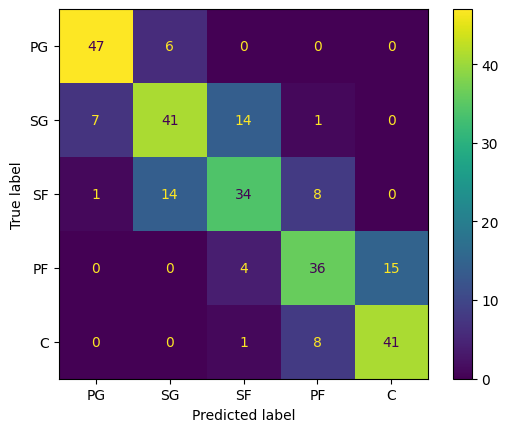

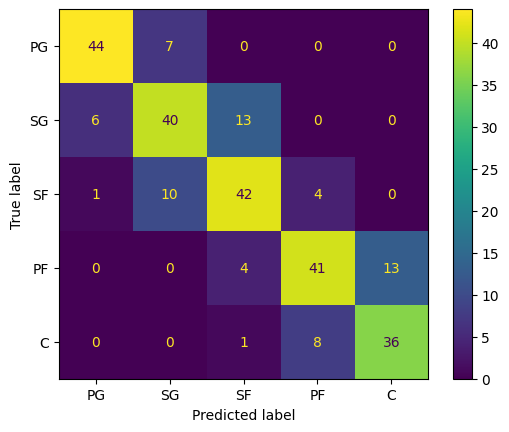

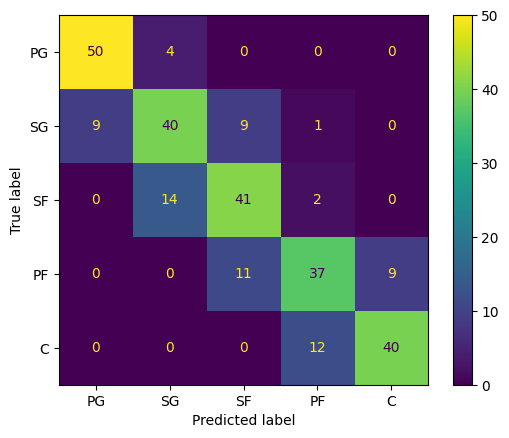

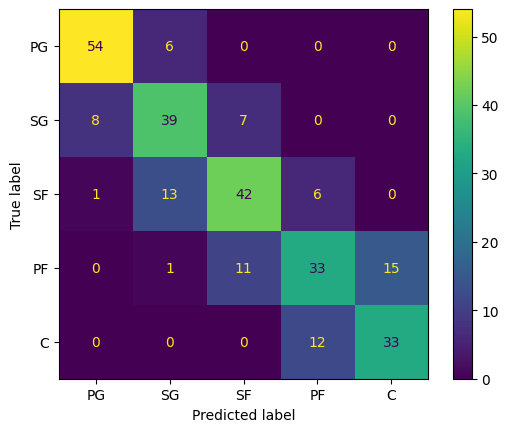

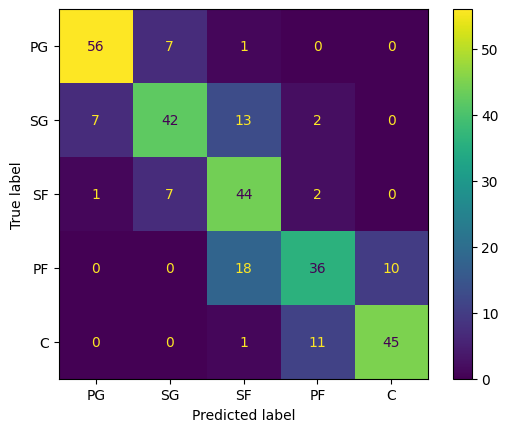

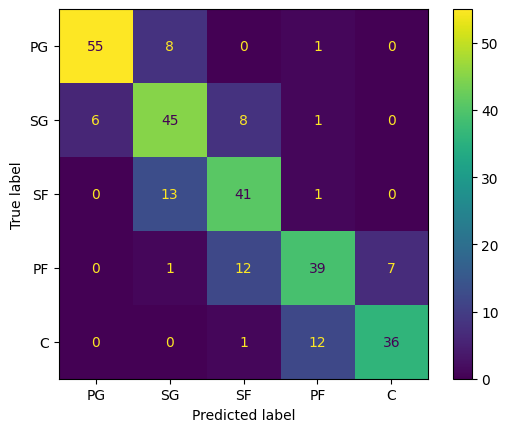

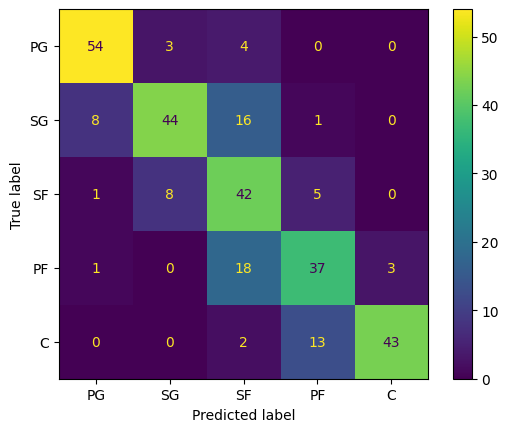

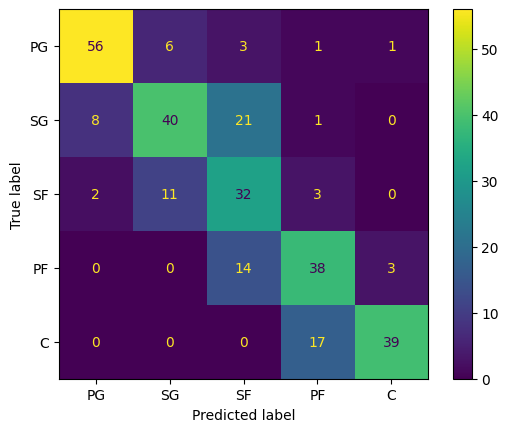

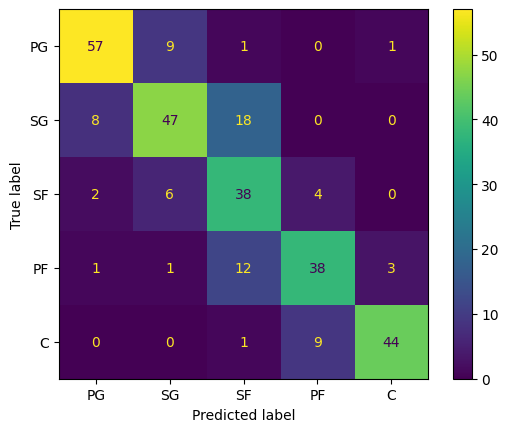

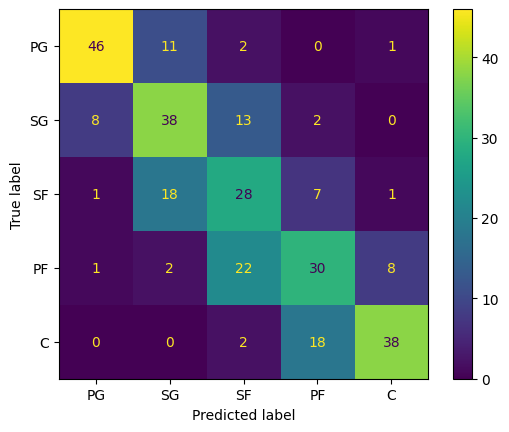

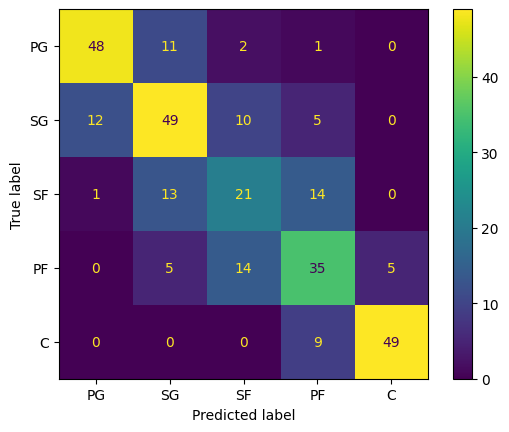

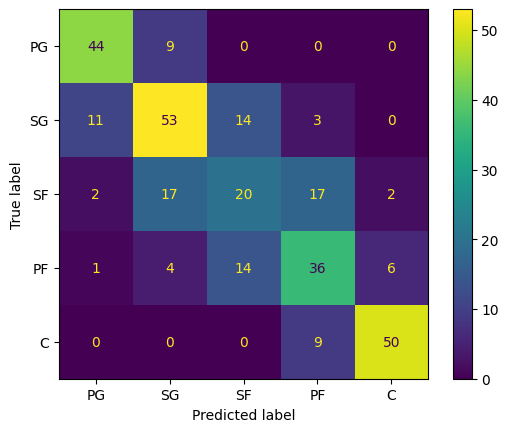

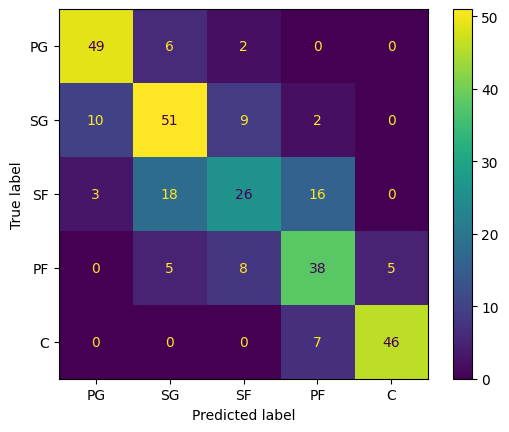

In [22]:
entropies_df, scores, feature_importances = classify_year_by_year(range(1980, 2019), 5)

<Axes: >

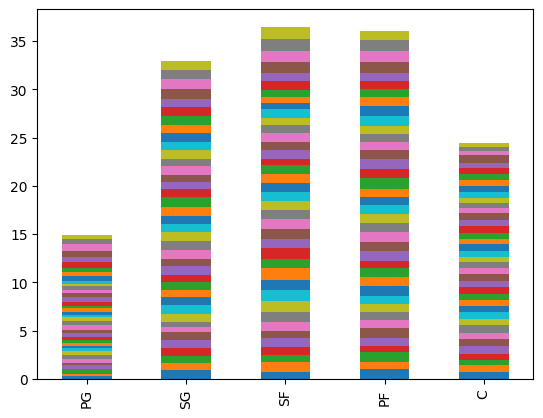

In [23]:
entropies_df.plot(kind='bar', stacked=True, legend=False)

<Axes: >

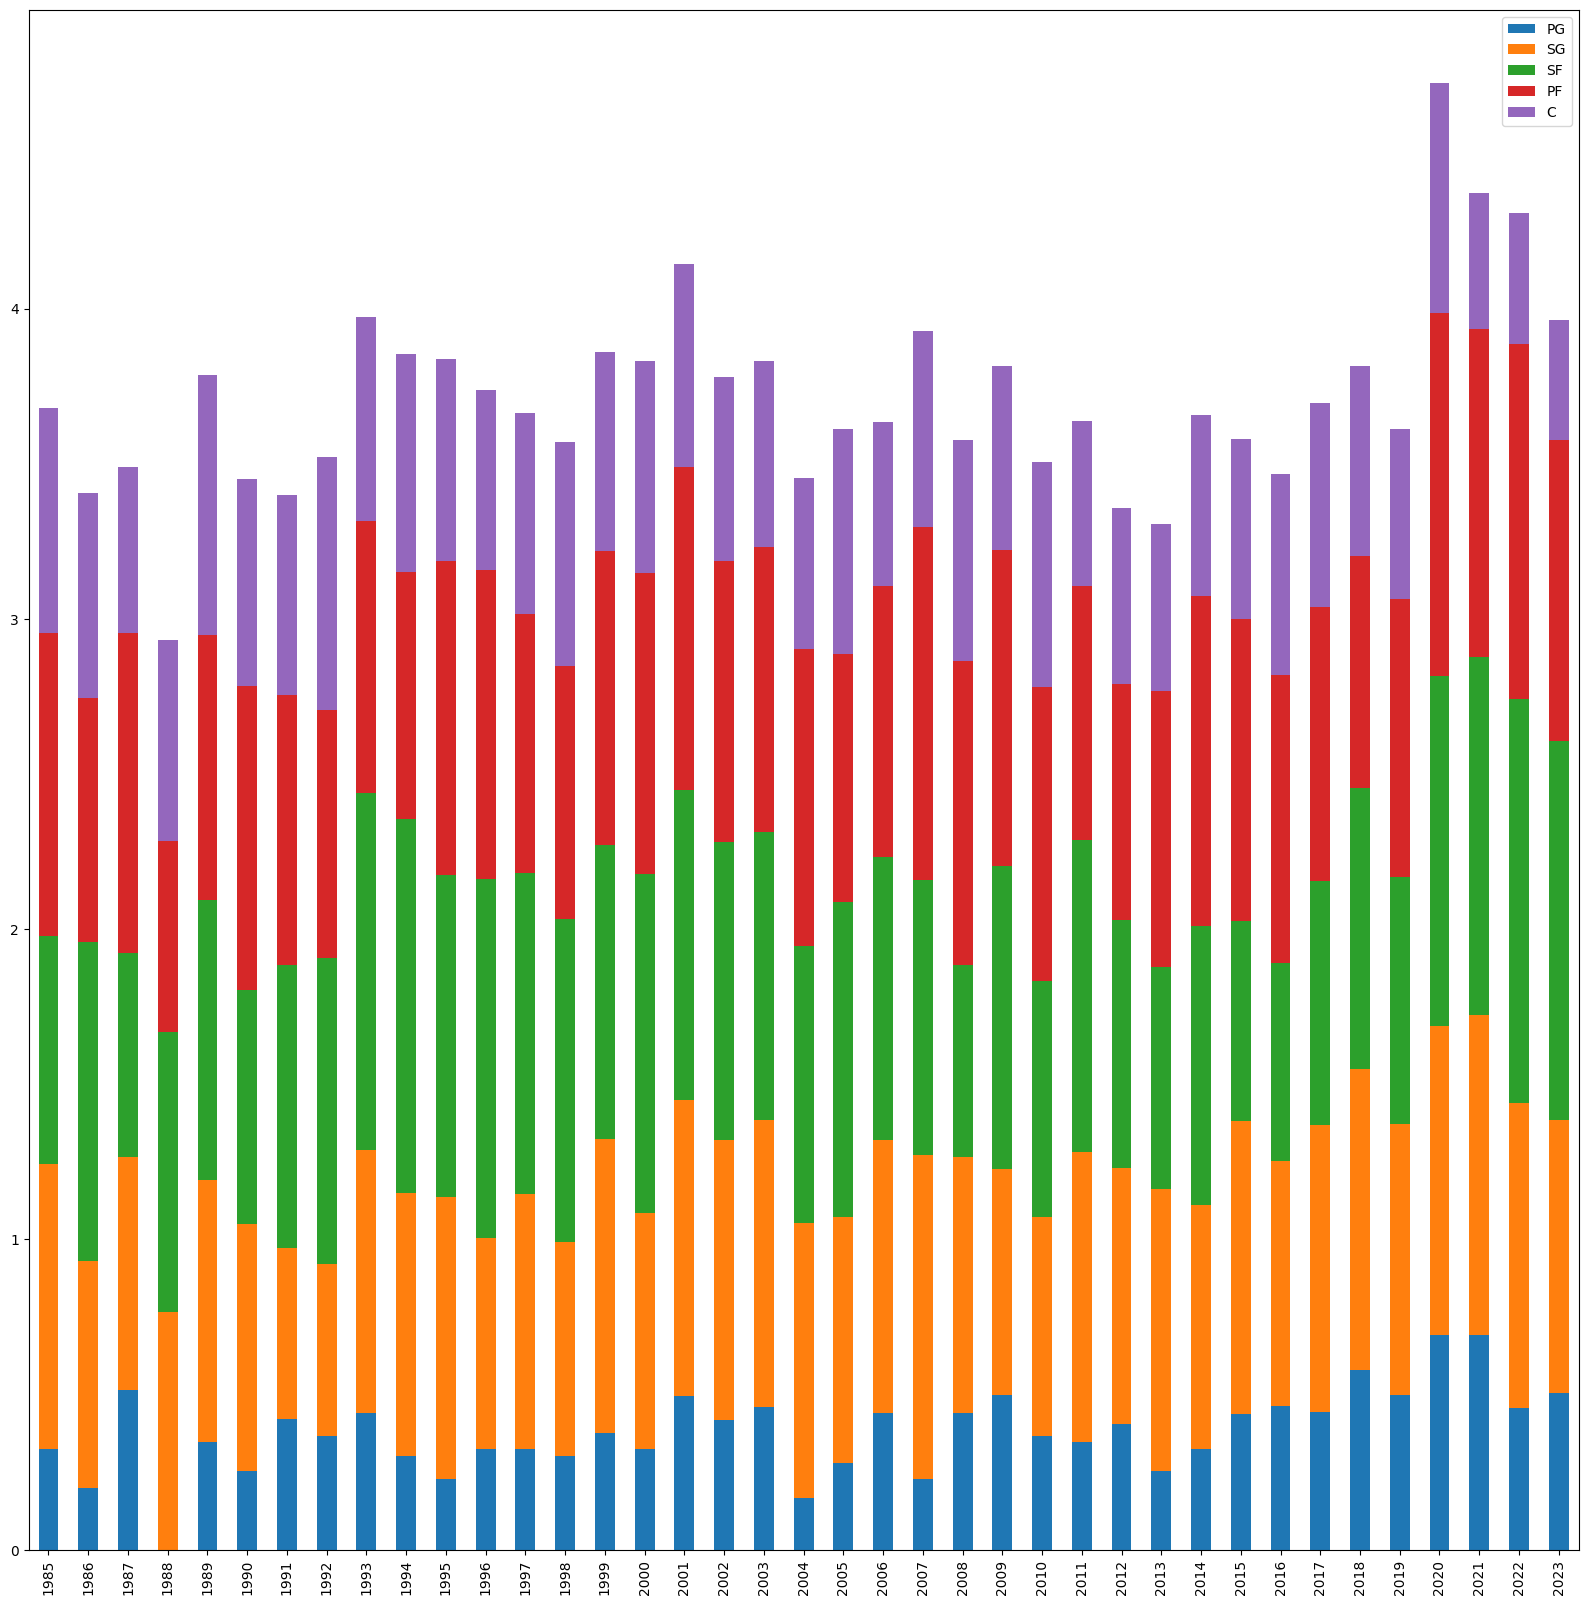

In [24]:
entropies_df.transpose().plot(kind='bar', stacked=True, figsize=(20,20))

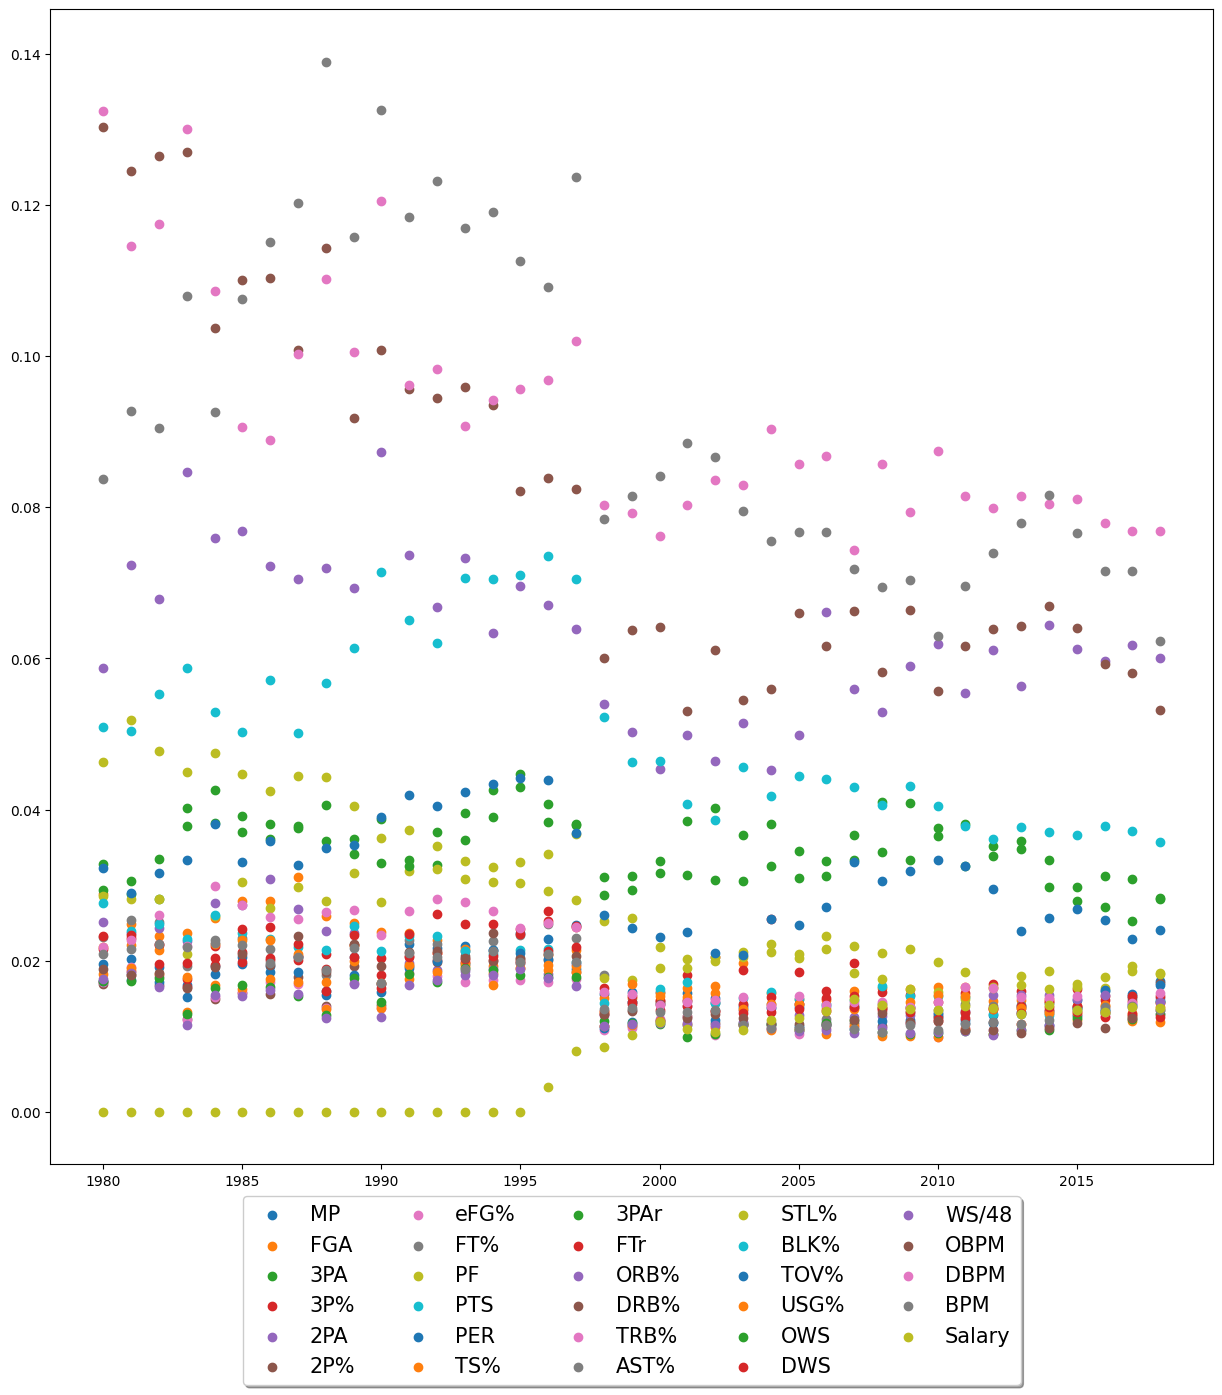

In [25]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=idx)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5, prop={'size': 15})

plt.show()

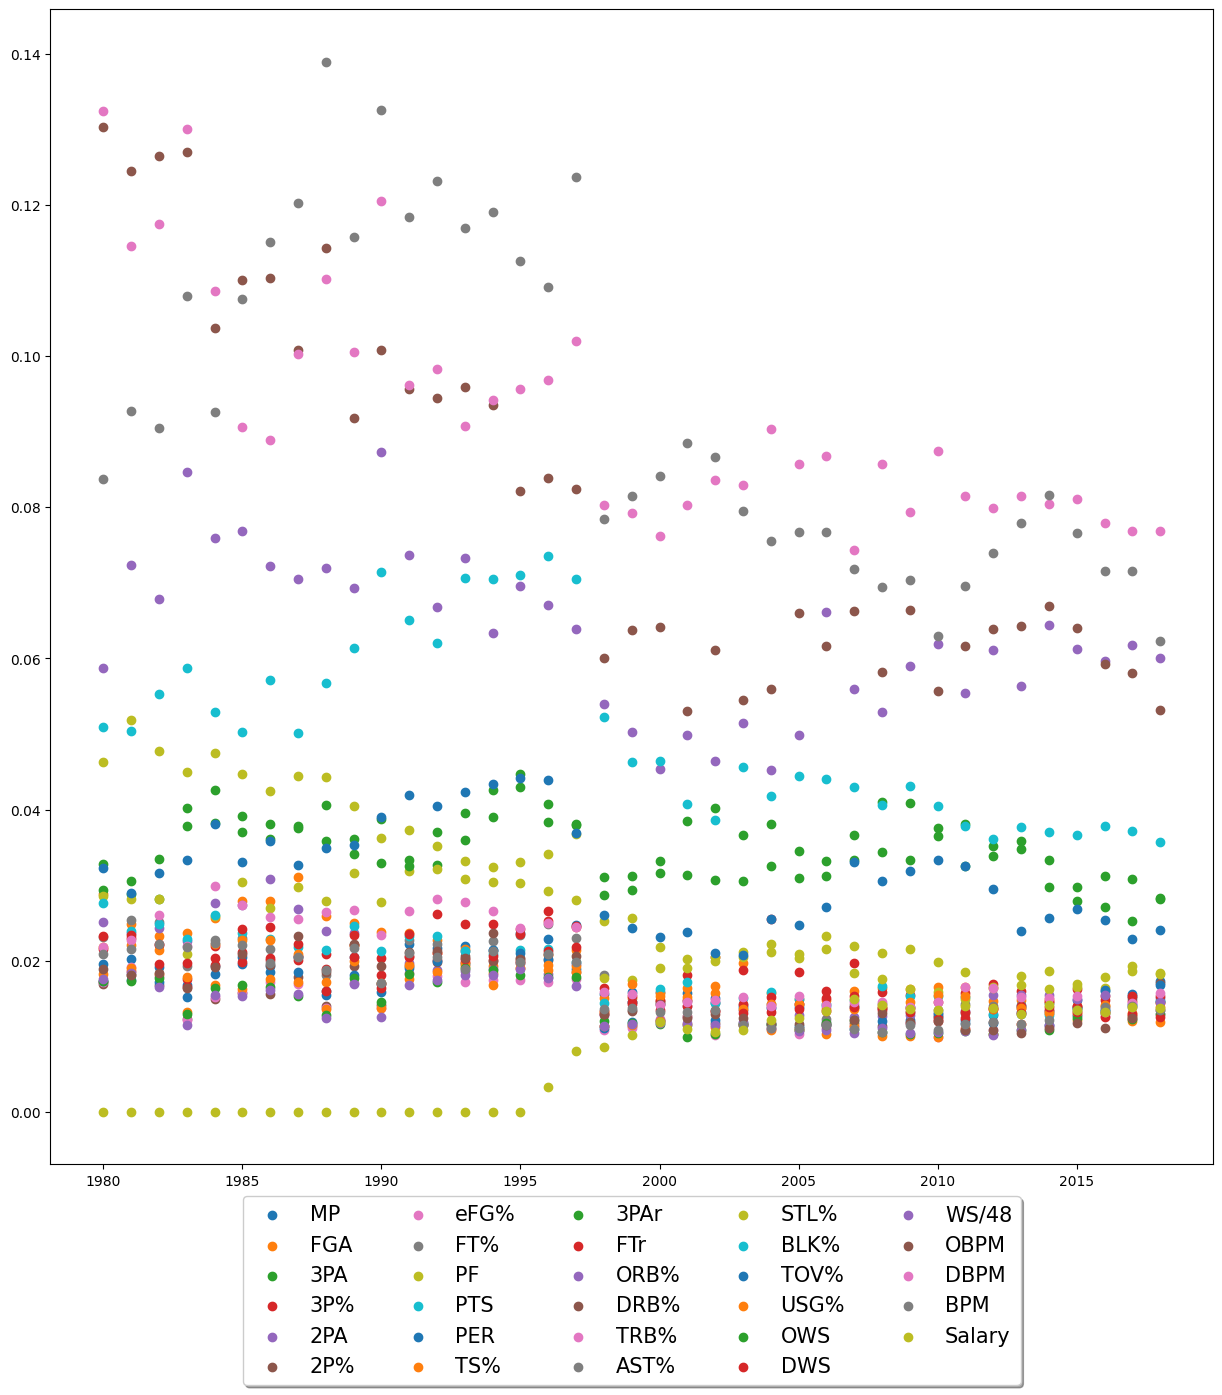

In [26]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=idx)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5, prop={'size': 15})

plt.show()

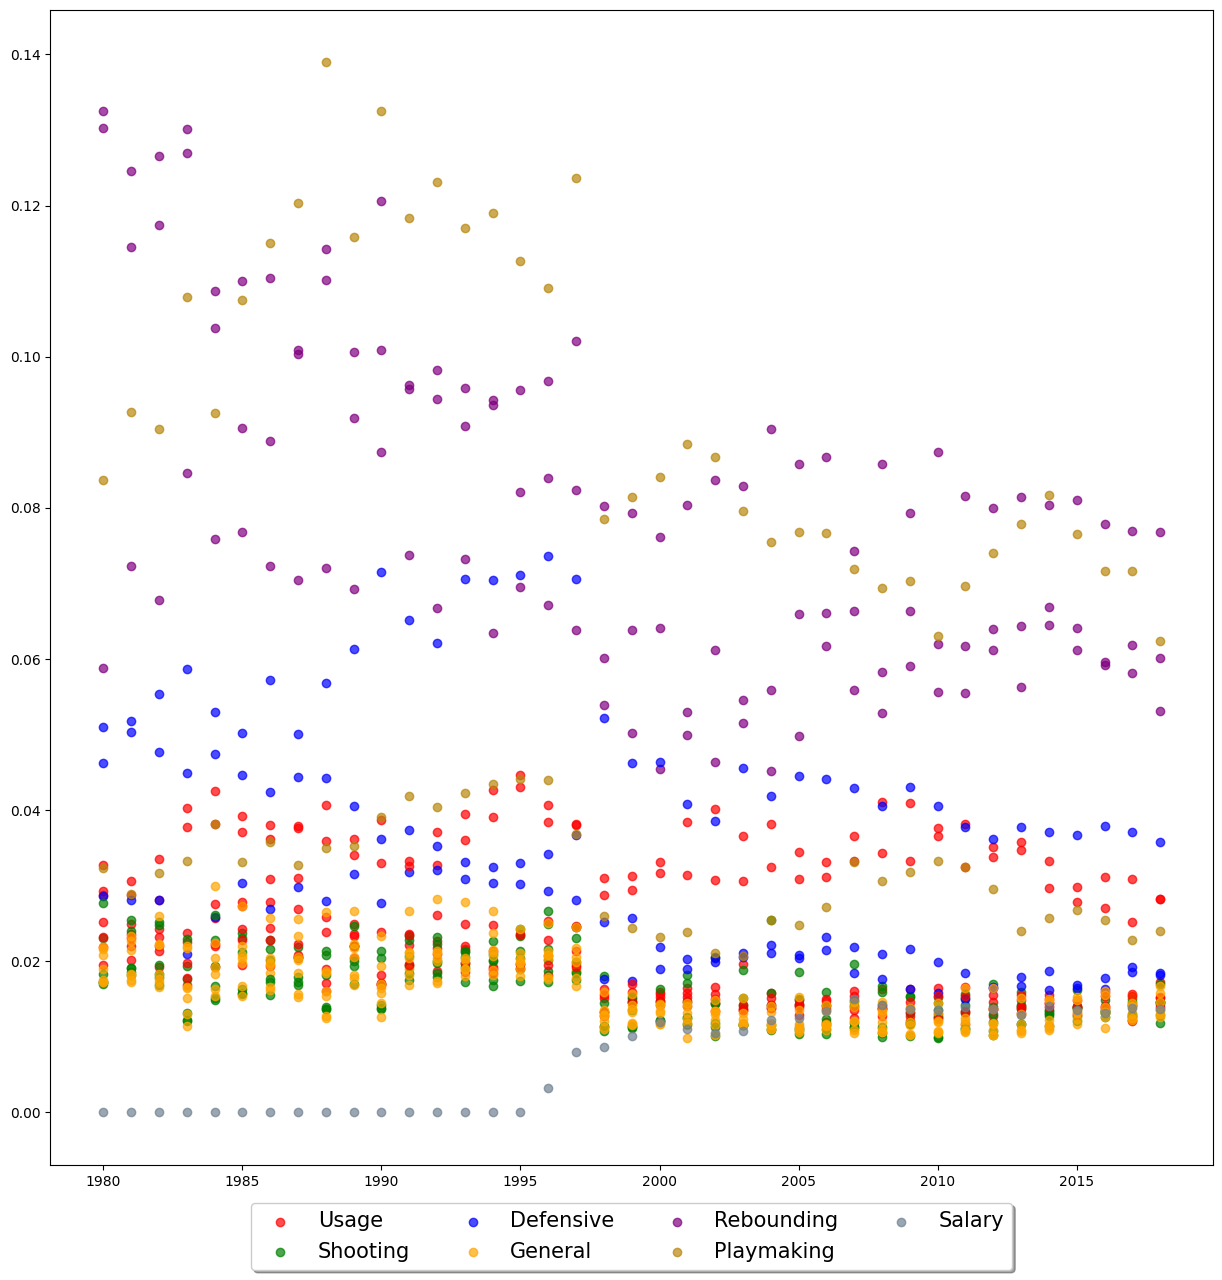

In [27]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=stats_mapper[idx], color=color_mapper[stats_mapper[idx]], alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='lower center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, prop={'size': 15})

plt.show()

In [28]:
transposed = entropies_df.transpose()
transposed.describe()

PG         SG         SF         PF          C
count  39.000000  39.000000  39.000000  39.000000  39.000000
mean    0.383266   0.843942   0.935330   0.924347   0.625402
std     0.135177   0.116339   0.172030   0.116797   0.095878
min     0.000000   0.548637   0.619921   0.615543   0.386387
25%     0.313147   0.776036   0.795879   0.846047   0.572710
50%     0.375123   0.848051   0.927789   0.928800   0.643566
75%     0.457587   0.925333   1.034824   0.988906   0.676531
max     0.693352   1.046044   1.301385   1.166791   0.837876